In [2]:
Kaggel = {"username":"vishal5050","key":"44a082b603938e8f31058ab2854f49d5"}

In [3]:
"""
Create a balanced 10K subset from Fruit-360 apples (21,444 images).
This maintains variety distribution while reducing training time.
"""

import os
import shutil
import random
from pathlib import Path

# ============================================
# CONFIGURATION
# ============================================
PROJECT_ROOT = '/Users/vishal/Desktop/ML study/project/CNN type/first'
FULL_APPLES = os.path.join(PROJECT_ROOT, 'fruit360_apples_only')
SUBSET_10K = os.path.join(PROJECT_ROOT, 'fruit360_apples_10k_subset')

TARGET_TRAIN_SIZE = 8000  # 8000 training images
TARGET_TEST_SIZE = 2000   # 2000 test images

random.seed(42)  # For reproducibility

print("="*70)
print("CREATING 10K APPLE SUBSET")
print("="*70)
print(f"\nSource: {FULL_APPLES}")
print(f"Target: {SUBSET_10K}")
print(f"Goal: 8000 train + 2000 test = 10,000 total images")
print("="*70)

# ============================================
# STEP 1: GET ALL VARIETIES
# ============================================
print("\nSTEP 1: Analyzing Original Dataset")
print("-"*70)

train_source = os.path.join(FULL_APPLES, 'Training')
test_source = os.path.join(FULL_APPLES, 'Test')

varieties = [d for d in os.listdir(train_source) 
             if os.path.isdir(os.path.join(train_source, d))]

print(f"Found {len(varieties)} apple varieties:")

# Count images per variety
variety_counts = {}
for variety in varieties:
    train_path = os.path.join(train_source, variety)
    test_path = os.path.join(test_source, variety)
    
    train_imgs = [f for f in os.listdir(train_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    test_imgs = [f for f in os.listdir(test_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    variety_counts[variety] = {
        'train': len(train_imgs),
        'test': len(test_imgs),
        'total': len(train_imgs) + len(test_imgs)
    }
    
    print(f"  {variety}: {len(train_imgs)} train, {len(test_imgs)} test")

total_train = sum(v['train'] for v in variety_counts.values())
total_test = sum(v['test'] for v in variety_counts.values())

print(f"\nOriginal totals: {total_train} train, {total_test} test = {total_train + total_test} total")

# ============================================
# STEP 2: CALCULATE SAMPLING RATIO
# ============================================
print("\nSTEP 2: Calculating Balanced Sample Size per Variety")
print("-"*70)

# Calculate how many images per variety (proportional sampling)
train_samples_per_variety = {}
test_samples_per_variety = {}

for variety in varieties:
    # Proportional to original distribution
    proportion = variety_counts[variety]['total'] / (total_train + total_test)
    
    train_target = int(TARGET_TRAIN_SIZE * proportion)
    test_target = int(TARGET_TEST_SIZE * proportion)
    
    # Ensure we don't sample more than available
    train_available = variety_counts[variety]['train']
    test_available = variety_counts[variety]['test']
    
    train_samples_per_variety[variety] = min(train_target, train_available)
    test_samples_per_variety[variety] = min(test_target, test_available)
    
    print(f"  {variety}: {train_samples_per_variety[variety]} train, {test_samples_per_variety[variety]} test")

actual_train_total = sum(train_samples_per_variety.values())
actual_test_total = sum(test_samples_per_variety.values())

print(f"\nActual subset size: {actual_train_total} train + {actual_test_total} test = {actual_train_total + actual_test_total} total")

# ============================================
# STEP 3: CREATE SUBSET
# ============================================
print("\nSTEP 3: Creating 10K Subset")
print("-"*70)

# Remove old subset if exists
if os.path.exists(SUBSET_10K):
    print("Removing old subset...")
    shutil.rmtree(SUBSET_10K)

# Create directories
train_output = os.path.join(SUBSET_10K, 'Training')
test_output = os.path.join(SUBSET_10K, 'Test')

os.makedirs(train_output, exist_ok=True)
os.makedirs(test_output, exist_ok=True)

# Sample and copy images
print("\nCopying sampled images...")

for variety in varieties:
    # Training images
    train_src = os.path.join(train_source, variety)
    train_dst = os.path.join(train_output, variety)
    os.makedirs(train_dst, exist_ok=True)
    
    all_train_imgs = [f for f in os.listdir(train_src) if f.endswith(('.jpg', '.jpeg', '.png'))]
    sampled_train = random.sample(all_train_imgs, train_samples_per_variety[variety])
    
    for img in sampled_train:
        shutil.copy2(os.path.join(train_src, img), os.path.join(train_dst, img))
    
    # Test images
    test_src = os.path.join(test_source, variety)
    test_dst = os.path.join(test_output, variety)
    os.makedirs(test_dst, exist_ok=True)
    
    all_test_imgs = [f for f in os.listdir(test_src) if f.endswith(('.jpg', '.jpeg', '.png'))]
    sampled_test = random.sample(all_test_imgs, test_samples_per_variety[variety])
    
    for img in sampled_test:
        shutil.copy2(os.path.join(test_src, img), os.path.join(test_dst, img))
    
    print(f"  ✓ {variety}: {len(sampled_train)} train, {len(sampled_test)} test copied")

# ============================================
# STEP 4: VERIFY SUBSET
# ============================================
print("\n" + "="*70)
print("VERIFICATION")
print("="*70)

# Count final images
final_train = 0
final_test = 0

for variety in varieties:
    train_path = os.path.join(train_output, variety)
    test_path = os.path.join(test_output, variety)
    
    train_count = len([f for f in os.listdir(train_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
    test_count = len([f for f in os.listdir(test_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
    
    final_train += train_count
    final_test += test_count

print(f"\nFinal subset:")
print(f"  Training:   {final_train} images")
print(f"  Test:       {final_test} images")
print(f"  Total:      {final_train + final_test} images")

reduction_percent = (1 - (final_train + final_test) / (total_train + total_test)) * 100
print(f"\nDataset reduced by {reduction_percent:.1f}%")

# ============================================
# STEP 5: SUMMARY
# ============================================
print("\n" + "="*70)
print("SUBSET CREATION COMPLETE!")
print("="*70)

print(f"\n✓ 10K subset saved to:")
print(f"  📁 {SUBSET_10K}")

print(f"\n✓ Structure:")
print(f"  Training/  ({final_train} images)")
print(f"  Test/      ({final_test} images)")

print(f"\n✓ All {len(varieties)} apple varieties included")
print(f"✓ Balanced proportional sampling maintained")

print("\n" + "="*70)
print("READY FOR PHASE 1 TRAINING!")
print("="*70)
print("\nExpected training time reduction:")
print(f"  Original (21K images):  33-52 hours")
print(f"  Subset (10K images):    15-25 hours")
print(f"  Time saved:             ~18-27 hours")
print("="*70)

CREATING 10K APPLE SUBSET

Source: /Users/vishal/Desktop/ML study/project/CNN type/first/fruit360_apples_only
Target: /Users/vishal/Desktop/ML study/project/CNN type/first/fruit360_apples_10k_subset
Goal: 8000 train + 2000 test = 10,000 total images

STEP 1: Analyzing Original Dataset
----------------------------------------------------------------------
Found 30 apple varieties:
  Apple 12: 466 train, 154 test
  Apple 5: 440 train, 146 test
  Apple Granny Smith 1: 492 train, 164 test
  Apple 13: 699 train, 235 test
  Apple 14: 466 train, 154 test
  Apple Braeburn 1: 492 train, 164 test
  Apple Golden 2: 492 train, 164 test
  Apple Red 1: 492 train, 164 test
  Apple Golden 3: 481 train, 161 test
  Apple Rotten 1: 488 train, 162 test
  Apple Red Yellow 1: 492 train, 164 test
  Apple Pink Lady 1: 456 train, 152 test
  Apple Core 1: 235 train, 78 test
  Apple 11: 430 train, 142 test
  Apple 6: 473 train, 157 test
  Apple 8: 687 train, 228 test
  Apple 18: 484 train, 160 test
  Apple 19: 7

                    PYRAMIDNET-18 ARCHITECTURE

📐 Building PyramidNet-18 (alpha=48)...

Channel progression through stages:
----------------------------------------------------------------------
Stage 1 (Conv2_x):
  Block 1: 16 → 22 filters
  Block 2: 22 → 28 filters

Stage 2 (Conv3_x):
  Block 1: 28 → 34 filters (stride=2)
  Block 2: 34 → 40 filters (stride=1)

Stage 3 (Conv4_x):
  Block 1: 40 → 46 filters (stride=2)
  Block 2: 46 → 52 filters (stride=1)

Stage 4 (Conv5_x):
  Block 1: 52 → 58 filters (stride=2)
  Block 2: 58 → 64 filters (stride=1)

MODEL SUMMARY


Model: "PyramidNet18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      2,352 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │         64 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      3,168 │ re_lu_1[0][0]     │
│                     │ 22)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │         88 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 22)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 22)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │      4,356 │ re_lu_2[0][0]     │
│                     │ 22)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │        352 │ max_pooling2d[0]… │
│                     │ 22)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ conv2d_2[0][0],   │
│                     │ 22)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │         88 │ add[0][0]         │
│ (BatchNormalizatio… │ 22)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 22)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │      5,544 │ re_lu_3[0][0]     │
│                     │ 28)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        112 │ conv2d_4[0][0]  

 Total params: 295,018 (1.13 MB)

 Trainable params: 293,578 (1.12 MB)

 Non-trainable params: 1,440 (5.62 KB)


KEY SPECIFICATIONS
Total parameters:     295,018
Architecture:         PyramidNet-18
Widening factor (α):  48
Starting filters:     16
Final filters:        ~64
Depth:                18 layers
Residual blocks:      8 (2 per stage)

ARCHITECTURE COMPARISON: ResNet vs PyramidNet

ResNet18 channel progression:
  Conv2_x: 64  → 64   (constant)
  Conv3_x: 64  → 128  (2x jump)
  Conv4_x: 128 → 256  (2x jump)
  Conv5_x: 256 → 512  (2x jump)

PyramidNet18 channel progression (α=48):
  Conv2_x: 16  → 22 → 28   (gradual +6)
  Conv3_x: 28  → 34 → 40   (gradual +6)
  Conv4_x: 40  → 46 → 52   (gradual +6)
  Conv5_x: 52  → 58 → 64   (gradual +6)

✨ Key Difference:
  ResNet:     Abrupt channel increases (step function)
  PyramidNet: Smooth channel increases (pyramid/linear)

BENEFITS OF PYRAMIDNET
✓ Smoother gradient flow (better optimization)
✓ More efficient parameter usage
✓ Potentially higher accuracy with same parameters
✓ Better feature representation


Generating architecture comparison visua

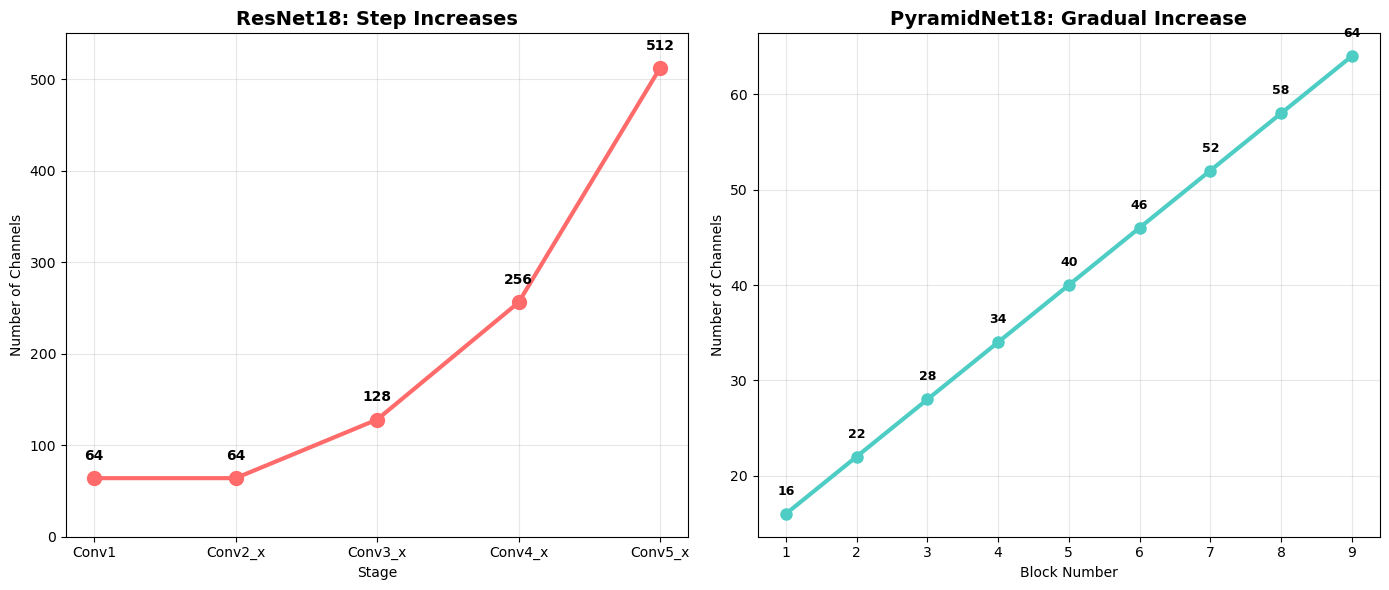


✅ PyramidNet-18 architecture is ready!


In [1]:
"""
PyramidNet-18 Complete Implementation
Based on: "Deep Pyramidal Residual Networks" (2017)
https://arxiv.org/abs/1610.02915

Architecture: Gradually increasing feature maps in a pyramid shape
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
from datetime import datetime

# ============================================
# PYRAMIDNET-18 ARCHITECTURE
# ============================================

def pyramidnet_basicblock(x, in_filters, out_filters, stride=1, shortcut_type='projection'):
    """
    PyramidNet Basic Block (similar to ResNet BasicBlock but with gradual channel increase)
    
    Args:
        x: Input tensor
        in_filters: Input channels
        out_filters: Output channels
        stride: Stride for downsampling
        shortcut_type: 'identity' or 'projection'
    """
    
    shortcut = x
    
    # First conv
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D( out_filters , 3, strides = stride , padding = 'same', use_bias = False )(x)
    
    # Second conv
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(out_filters, 3, strides=1, padding='same', use_bias=False)(x)
    
    # Shortcut connection
    if in_filters != out_filters or stride != 1:
        # Need to adjust shortcut dimensions
        if shortcut_type == 'projection':
            shortcut = layers.Conv2D(out_filters, 1, strides=stride, use_bias=False)(shortcut)
        else:
            # Zero-padding shortcut (save parameters)
            shortcut = layers.AveragePooling2D(stride, stride)(shortcut) if stride > 1 else shortcut
            # Pad channels with zeros
            pad_filters = out_filters - in_filters
            if pad_filters > 0:
                shortcut = layers.Lambda(
                    lambda x: tf.pad(x, [[0, 0], [0, 0], [0, 0], [0, pad_filters]])
                )(shortcut)
    
    # Add residual
    x = layers.Add()([x, shortcut])
    
    return x

def build_pyramidnet18(num_classes, alpha=48, input_shape=(224, 224, 3)):
    """
    Build PyramidNet-18 architecture
    
    Args:
        num_classes: Number of output classes
        alpha: Widening factor (determines how much channels increase)
        input_shape: Input image shape
    
    Architecture:
        Layer       | Blocks | Output Size | Filters (start → end)
        ------------|--------|-------------|----------------------
        Conv1       | 1      | 112×112     | 16
        Conv2_x     | 2      | 56×56       | 16 → 32
        Conv3_x     | 2      | 28×28       | 32 → 64
        Conv4_x     | 2      | 14×14       | 64 → 96
        Conv5_x     | 2      | 7×7         | 96 → 128
        GAP + FC    | 1      | 1×1         | num_classes
        
    Total: ~11M parameters (similar to ResNet18)
    """
    
    # Calculate channel increases
    # With 4 stages and 2 blocks per stage = 8 blocks total
    num_blocks = 8
    add_channels_per_block = alpha / num_blocks  # Gradual increase
    
    inputs = layers.Input(shape=input_shape)
    
    # Initial Conv
    start_filters = 16
    x = layers.Conv2D(start_filters, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    current_filters = start_filters
    
    # Stage 1: Conv2_x (2 blocks, 56×56)
    print("Stage 1 (Conv2_x):")
    for i in range(2):
        out_filters = int(start_filters + add_channels_per_block * (i + 1))
        print(f"  Block {i+1}: {int(current_filters)} → {out_filters} filters")
        x = pyramidnet_basicblock(x, int(current_filters), out_filters, stride=1)
        current_filters = out_filters
    
    # Stage 2: Conv3_x (2 blocks, 28×28, downsample at first block)
    print("\nStage 2 (Conv3_x):")
    for i in range(2):
        out_filters = int(start_filters + add_channels_per_block * (2 + i + 1))
        stride = 2 if i == 0 else 1
        print(f"  Block {i+1}: {int(current_filters)} → {out_filters} filters (stride={stride})")
        x = pyramidnet_basicblock(x, int(current_filters), out_filters, stride=stride)
        current_filters = out_filters
    
    # Stage 3: Conv4_x (2 blocks, 14×14, downsample at first block)
    print("\nStage 3 (Conv4_x):")
    for i in range(2):
        out_filters = int(start_filters + add_channels_per_block * (4 + i + 1))
        stride = 2 if i == 0 else 1
        print(f"  Block {i+1}: {int(current_filters)} → {out_filters} filters (stride={stride})")
        x = pyramidnet_basicblock(x, int(current_filters), out_filters, stride=stride)
        current_filters = out_filters
    
    # Stage 4: Conv5_x (2 blocks, 7×7, downsample at first block)
    print("\nStage 4 (Conv5_x):")
    for i in range(2):
        out_filters = int(start_filters + add_channels_per_block * (6 + i + 1))
        stride = 2 if i == 0 else 1
        print(f"  Block {i+1}: {int(current_filters)} → {out_filters} filters (stride={stride})")
        x = pyramidnet_basicblock(x, int(current_filters), out_filters, stride=stride)
        current_filters = out_filters
    
    # Final layers
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name='PyramidNet18')
    
    return model

# ============================================
# VISUALIZATION: Architecture Comparison
# ============================================

def visualize_architecture_comparison():
    """
    Visualize channel progression: ResNet vs PyramidNet
    """
    
    # ResNet18 channel progression
    resnet_stages = ['Conv1', 'Conv2_x', 'Conv3_x', 'Conv4_x', 'Conv5_x']
    resnet_channels = [64, 64, 128, 256, 512]
    
    # PyramidNet18 channel progression (alpha=48)
    pyramid_stages = ['Conv1', 'Conv2_x\nBlock1', 'Conv2_x\nBlock2', 
                      'Conv3_x\nBlock1', 'Conv3_x\nBlock2',
                      'Conv4_x\nBlock1', 'Conv4_x\nBlock2',
                      'Conv5_x\nBlock1', 'Conv5_x\nBlock2']
    pyramid_channels = [16, 22, 28, 34, 40, 46, 52, 58, 64]
    
    plt.figure(figsize=(14, 6))
    
    # ResNet progression
    plt.subplot(1, 2, 1)
    plt.plot(resnet_stages, resnet_channels, 'o-', linewidth=3, markersize=10, color='#FF6B6B')
    plt.title('ResNet18: Step Increases', fontsize=14, fontweight='bold')
    plt.xlabel('Stage')
    plt.ylabel('Number of Channels')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 550)
    for i, (stage, ch) in enumerate(zip(resnet_stages, resnet_channels)):
        plt.text(i, ch + 20, str(ch), ha='center', fontweight='bold')
    
    # PyramidNet progression
    plt.subplot(1, 2, 2)
    plt.plot(range(len(pyramid_channels)), pyramid_channels, 'o-', 
             linewidth=3, markersize=8, color='#4ECDC4')
    plt.title('PyramidNet18: Gradual Increase', fontsize=14, fontweight='bold')
    plt.xlabel('Block Number')
    plt.ylabel('Number of Channels')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(len(pyramid_channels)), range(1, len(pyramid_channels)+1))
    for i, ch in enumerate(pyramid_channels):
        plt.text(i, ch + 2, str(ch), ha='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('pyramidnet_vs_resnet_architecture.png', dpi=300, bbox_inches='tight')
    print("\n✓ Architecture comparison saved: pyramidnet_vs_resnet_architecture.png")
    plt.show()

# ============================================
# BUILD AND DISPLAY MODEL
# ============================================

if __name__ == "__main__":
    print("="*70)
    print(" "*20 + "PYRAMIDNET-18 ARCHITECTURE")
    print("="*70)
    
    print("\n📐 Building PyramidNet-18 (alpha=48)...")
    print("\nChannel progression through stages:")
    print("-"*70)
    
    # Build model
    model = build_pyramidnet18(num_classes=10, alpha=48)  # Example with 10 classes
    
    print("\n" + "="*70)
    print("MODEL SUMMARY")
    print("="*70)
    
    model.summary()
    
    print("\n" + "="*70)
    print("KEY SPECIFICATIONS")
    print("="*70)
    print(f"Total parameters:     {model.count_params():,}")
    print(f"Architecture:         PyramidNet-18")
    print(f"Widening factor (α):  48")
    print(f"Starting filters:     16")
    print(f"Final filters:        ~64")
    print(f"Depth:                18 layers")
    print(f"Residual blocks:      8 (2 per stage)")
    
    print("\n" + "="*70)
    print("ARCHITECTURE COMPARISON: ResNet vs PyramidNet")
    print("="*70)
    
    print("\nResNet18 channel progression:")
    print("  Conv2_x: 64  → 64   (constant)")
    print("  Conv3_x: 64  → 128  (2x jump)")
    print("  Conv4_x: 128 → 256  (2x jump)")
    print("  Conv5_x: 256 → 512  (2x jump)")
    
    print("\nPyramidNet18 channel progression (α=48):")
    print("  Conv2_x: 16  → 22 → 28   (gradual +6)")
    print("  Conv3_x: 28  → 34 → 40   (gradual +6)")
    print("  Conv4_x: 40  → 46 → 52   (gradual +6)")
    print("  Conv5_x: 52  → 58 → 64   (gradual +6)")
    
    print("\n✨ Key Difference:")
    print("  ResNet:     Abrupt channel increases (step function)")
    print("  PyramidNet: Smooth channel increases (pyramid/linear)")
    
    print("\n" + "="*70)
    print("BENEFITS OF PYRAMIDNET")
    print("="*70)
    print("✓ Smoother gradient flow (better optimization)")
    print("✓ More efficient parameter usage")
    print("✓ Potentially higher accuracy with same parameters")
    print("✓ Better feature representation")
    
    print("\n" + "="*70)
    
    # Visualize
    print("\nGenerating architecture comparison visualization...")
    visualize_architecture_comparison()
    
    print("\n" + "="*70)
    print("✅ PyramidNet-18 architecture is ready!")
    print("="*70)

In [3]:
"""
PyramidNet-18 Complete Training Pipeline:
1. Pre-train from scratch on Fruit-360 apples (10K subset)
2. Fine-tune on your curated handpicked data (800 images)
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
from datetime import datetime

# ============================================
# CONFIGURATION
# ============================================
PROJECT_ROOT = '/Users/vishal/Desktop/ML study/project/CNN type/first'

FRUIT360_10K = os.path.join(PROJECT_ROOT, 'fruit360_apples_10k_subset')
CURATED_DATA = os.path.join(PROJECT_ROOT, 'data set fine tune')

PRETRAIN_MODEL_PATH = os.path.join(PROJECT_ROOT, 'pyramidnet18_pretrained.keras')
FINETUNE_MODEL_PATH = os.path.join(PROJECT_ROOT, 'pyramidnet18_finetuned.keras')
RESULTS_PATH = os.path.join(PROJECT_ROOT, 'pyramidnet18_results')

os.makedirs(RESULTS_PATH, exist_ok=True)

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
PRETRAIN_EPOCHS = 100
FINETUNE_EPOCHS = 50

print("="*70)
print(" "*12 + "PYRAMIDNET-18 COMPLETE TRAINING PIPELINE")
print("="*70)
print("\nPhase 1: Pre-train on Fruit-360 (10K images)")
print("Phase 2: Fine-tune on your curated data (800 images)")
print("="*70)

# ============================================
# PYRAMIDNET-18 ARCHITECTURE
# ============================================

def pyramidnet_basicblock(x, in_filters, out_filters, stride=1):
    """PyramidNet Basic Block"""
    shortcut = x
    
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(out_filters, 3, strides=stride, padding='same', use_bias=False)(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(out_filters, 3, strides=1, padding='same', use_bias=False)(x)
    
    if in_filters != out_filters or stride != 1:
        shortcut = layers.Conv2D(out_filters, 1, strides=stride, use_bias=False)(shortcut)
    
    x = layers.Add()([x, shortcut])
    return x

def build_pyramidnet18(num_classes, alpha=48, input_shape=(224, 224, 3)):
    """Build PyramidNet-18"""
    
    num_blocks = 8
    add_channels_per_block = alpha / num_blocks
    
    inputs = layers.Input(shape=input_shape)
    
    start_filters = 16
    x = layers.Conv2D(start_filters, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    current_filters = start_filters
    
    # Stage 1: Conv2_x (2 blocks)
    for i in range(2):
        out_filters = int(start_filters + add_channels_per_block * (i + 1))
        x = pyramidnet_basicblock(x, int(current_filters), out_filters, stride=1)
        current_filters = out_filters
    
    # Stage 2: Conv3_x (2 blocks)
    for i in range(2):
        out_filters = int(start_filters + add_channels_per_block * (2 + i + 1))
        stride = 2 if i == 0 else 1
        x = pyramidnet_basicblock(x, int(current_filters), out_filters, stride=stride)
        current_filters = out_filters
    
    # Stage 3: Conv4_x (2 blocks)
    for i in range(2):
        out_filters = int(start_filters + add_channels_per_block * (4 + i + 1))
        stride = 2 if i == 0 else 1
        x = pyramidnet_basicblock(x, int(current_filters), out_filters, stride=stride)
        current_filters = out_filters
    
    # Stage 4: Conv5_x (2 blocks)
    for i in range(2):
        out_filters = int(start_filters + add_channels_per_block * (6 + i + 1))
        stride = 2 if i == 0 else 1
        x = pyramidnet_basicblock(x, int(current_filters), out_filters, stride=stride)
        current_filters = out_filters
    
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name='PyramidNet18')
    return model

# ============================================
# PHASE 1: PRE-TRAINING
# ============================================
print("\n" + "="*70)
print("PHASE 1: PRE-TRAINING ON FRUIT-360")
print("="*70)

print("\nLoading Fruit-360 data (10K subset)...")

pretrain_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    zoom_range=0.2,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

pretrain_train = pretrain_datagen.flow_from_directory(
    os.path.join(FRUIT360_10K, 'Training'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

pretrain_val = pretrain_datagen.flow_from_directory(
    os.path.join(FRUIT360_10K, 'Training'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

pretrain_test = test_datagen.flow_from_directory(
    os.path.join(FRUIT360_10K, 'Test'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_pretrain_classes = pretrain_train.num_classes

print(f"\n✓ Data loaded:")
print(f"  Training:   {pretrain_train.samples} images")
print(f"  Validation: {pretrain_val.samples} images")
print(f"  Test:       {pretrain_test.samples} images")
print(f"  Classes:    {num_pretrain_classes}")

print("\nBuilding PyramidNet-18 from scratch...")
pretrain_model = build_pyramidnet18(num_classes=num_pretrain_classes, alpha=48)

print(f"✓ Model built: {pretrain_model.count_params():,} parameters")

pretrain_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

pretrain_callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7, verbose=1),
    ModelCheckpoint(PRETRAIN_MODEL_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)
]

print(f"\nStarting pre-training at {datetime.now().strftime('%H:%M:%S')}")
print(f"Expected time: 6-10 hours")
print("="*70)

pretrain_start = time.time()

pretrain_history = pretrain_model.fit(
    pretrain_train,
    epochs=PRETRAIN_EPOCHS,
    validation_data=pretrain_val,
    callbacks=pretrain_callbacks,
    verbose=1
)

pretrain_time = time.time() - pretrain_start

print(f"\n✓ Pre-training complete in {pretrain_time/3600:.2f} hours")

pretrain_test_loss, pretrain_test_acc = pretrain_model.evaluate(pretrain_test, verbose=0)

print(f"\n✓ Pre-training results:")
print(f"  Test Accuracy: {pretrain_test_acc*100:.2f}%")
print(f"  Test Loss: {pretrain_test_loss:.4f}")

pd.DataFrame(pretrain_history.history).to_csv(
    os.path.join(RESULTS_PATH, 'pretrain_history.csv'), index=False)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(pretrain_history.history['accuracy'], label='Train', linewidth=2)
plt.plot(pretrain_history.history['val_accuracy'], label='Val', linewidth=2)
plt.title('Pre-training: Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(pretrain_history.history['loss'], label='Train', linewidth=2)
plt.plot(pretrain_history.history['val_loss'], label='Val', linewidth=2)
plt.title('Pre-training: Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'pretrain_curves.png'), dpi=300)
plt.close()

# ============================================
# PHASE 2: FINE-TUNING
# ============================================
print("\n" + "="*70)
print("PHASE 2: FINE-TUNING ON YOUR CURATED DATA")
print("="*70)

print("\nLoading your curated data...")

finetune_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    zoom_range=0.2,
    validation_split=0.25
)

finetune_train = finetune_datagen.flow_from_directory(
    CURATED_DATA,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

finetune_val = finetune_datagen.flow_from_directory(
    CURATED_DATA,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

num_finetune_classes = finetune_train.num_classes

print(f"\n✓ Data loaded:")
print(f"  Training:   {finetune_train.samples} images")
print(f"  Validation: {finetune_val.samples} images")
print(f"  Classes:    {num_finetune_classes}")

print("\nAdapting model for fine-tuning...")

pretrained_model = keras.models.load_model(PRETRAIN_MODEL_PATH)

finetune_model = build_pyramidnet18(num_classes=num_finetune_classes, alpha=48)

for pretrained_layer, finetune_layer in zip(pretrained_model.layers[:-1], finetune_model.layers[:-1]):
    if len(pretrained_layer.get_weights()) > 0:
        finetune_layer.set_weights(pretrained_layer.get_weights())

print("✓ Pre-trained weights loaded")

total_layers = len(finetune_model.layers)
freeze_until = int(total_layers * 0.6)

for i, layer in enumerate(finetune_model.layers):
    layer.trainable = (i >= freeze_until)

trainable = sum([1 for layer in finetune_model.layers if layer.trainable])
print(f"✓ Frozen: {freeze_until}/{total_layers}, Trainable: {trainable}/{total_layers}")

finetune_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

finetune_callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-8, verbose=1),
    ModelCheckpoint(FINETUNE_MODEL_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)
]

print(f"\nStarting fine-tuning at {datetime.now().strftime('%H:%M:%S')}")
print(f"Expected time: 30-60 minutes")
print("="*70)

finetune_start = time.time()

finetune_history = finetune_model.fit(
    finetune_train,
    epochs=FINETUNE_EPOCHS,
    validation_data=finetune_val,
    callbacks=finetune_callbacks,
    verbose=1
)

finetune_time = time.time() - finetune_start

print(f"\n✓ Fine-tuning complete in {finetune_time/60:.1f} minutes")

finetune_val_loss, finetune_val_acc = finetune_model.evaluate(finetune_val, verbose=0)

print(f"\n✓ Fine-tuning results:")
print(f"  Validation Accuracy: {finetune_val_acc*100:.2f}%")
print(f"  Validation Loss: {finetune_val_loss:.4f}")

pd.DataFrame(finetune_history.history).to_csv(
    os.path.join(RESULTS_PATH, 'finetune_history.csv'), index=False)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(finetune_history.history['accuracy'], label='Train', linewidth=2)
plt.plot(finetune_history.history['val_accuracy'], label='Val', linewidth=2)
plt.title('Fine-tuning: Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(finetune_history.history['loss'], label='Train', linewidth=2)
plt.plot(finetune_history.history['val_loss'], label='Val', linewidth=2)
plt.title('Fine-tuning: Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'finetune_curves.png'), dpi=300)
plt.close()

# ============================================
# SUMMARY
# ============================================
print("\n" + "="*70)
print("PYRAMIDNET-18 PIPELINE COMPLETE!")
print("="*70)

print(f"\n📊 FINAL RESULTS:")
print(f"\nPhase 1 - Pre-training:")
print(f"  Time:     {pretrain_time/3600:.2f} hours")
print(f"  Accuracy: {pretrain_test_acc*100:.2f}%")
print(f"  Model:    {PRETRAIN_MODEL_PATH}")

print(f"\nPhase 2 - Fine-tuning:")
print(f"  Time:     {finetune_time/60:.1f} minutes")
print(f"  Accuracy: {finetune_val_acc*100:.2f}%")
print(f"  Model:    {FINETUNE_MODEL_PATH}")

print(f"\n📁 Results: {RESULTS_PATH}/")
print(f"  - pretrain_history.csv")
print(f"  - pretrain_curves.png")
print(f"  - finetune_history.csv")
print(f"  - finetune_curves.png")


print("\n" + "="*70)
print("✅ PyramidNet-18 trained and ready!")
print("="*70)

            PYRAMIDNET-18 COMPLETE TRAINING PIPELINE

Phase 1: Pre-train on Fruit-360 (10K images)
Phase 2: Fine-tune on your curated data (800 images)

PHASE 1: PRE-TRAINING ON FRUIT-360

Loading Fruit-360 data (10K subset)...
Found 6400 images belonging to 30 classes.
Found 1583 images belonging to 30 classes.
Found 1988 images belonging to 30 classes.

✓ Data loaded:
  Training:   6400 images
  Validation: 1583 images
  Test:       1988 images
  Classes:    30

Building PyramidNet-18 from scratch...
✓ Model built: 296,318 parameters

Starting pre-training at 07:08:03
Expected time: 6-10 hours


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.1837 - loss: 2.9035
Epoch 1: val_accuracy improved from -inf to 0.02653, saving model to /Users/vishal/Desktop/ML study/project/CNN type/first/pyramidnet18_pretrained.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 54s 261ms/step - accuracy: 0.1842 - loss: 2.9012 - val_accuracy: 0.0265 - val_loss: 9.2804 - learning_rate: 0.0010
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.5080 - loss: 1.6702
Epoch 2: val_accuracy improved from 0.02653 to 0.27543, saving model to /Users/vishal/Desktop/ML study/project/CNN type/first/pyramidnet18_pretrained.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 54s 272ms/step - accuracy: 0.5082 - loss: 1.6695 - val_accuracy: 0.2754 - val_loss: 3.0115 - learning_rate: 0.0010
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.6445 - loss: 1.1985
Epoch 3: val_accuracy improved from 0.27543 to 0.48958, saving model to /Users/vishal/Desktop/ML study/project/CNN type/first/pyramidnet

/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 1: val_accuracy improved from -inf to 0.11905, saving model to /Users/vishal/Desktop/ML study/project/CNN type/first/pyramidnet18_finetuned.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - accuracy: 0.1687 - loss: 4.0181 - val_accuracy: 0.1190 - val_loss: 3.6095 - learning_rate: 1.0000e-04
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.1496 - loss: 3.8576
Epoch 2: val_accuracy improved from 0.11905 to 0.13095, saving model to /Users/vishal/Desktop/ML study/project/CNN type/first/pyramidnet18_finetuned.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.1493 - loss: 3.8553 - val_accuracy: 0.1310 - val_loss: 2.9442 - learning_rate: 1.0000e-04
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.1510 - loss: 3.5840
Epoch 3: val_accuracy improved from 0.13095 to 0.14286, saving model to /Users/vishal/Desktop/ML study/project/CNN type/first/pyramidnet18_finetuned.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.1511 - loss: 3.5797 

# EXPERIMENT 1: Unfreeze All Layers

In [4]:
"""
EXPERIMENT 1: Unfreeze All Layers

Baseline: 55.36% val accuracy (60% frozen)
Change: Unfreeze ALL layers (0% frozen)
Keep same: Learning rate 0.0001, Max epochs 50

Goal: Test if freezing was the problem
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
from datetime import datetime

# ============================================
# CONFIGURATION
# ============================================
PROJECT_ROOT = '/Users/vishal/Desktop/ML study/project/CNN type/first'

CURATED_DATA = os.path.join(PROJECT_ROOT, 'data set fine tune')
PRETRAIN_MODEL_PATH = os.path.join(PROJECT_ROOT, 'pyramidnet18_pretrained.keras')

# Experiment 1 outputs
EXP1_MODEL_PATH = os.path.join(PROJECT_ROOT, 'experiment1_model.keras')
EXP1_RESULTS_PATH = os.path.join(PROJECT_ROOT, 'experiment1_results')

os.makedirs(EXP1_RESULTS_PATH, exist_ok=True)

# Parameters (KEEP SAME AS BASELINE except unfreezing)
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 50  # Same as baseline
LEARNING_RATE = 0.0001  # Same as baseline

print("="*70)
print(" "*10 + "EXPERIMENT 1: UNFREEZE ALL LAYERS")
print("="*70)
print("\n📊 BASELINE (Previous Run):")
print("  Frozen layers: 60%")
print("  Learning rate: 0.0001")
print("  Max epochs: 50")
print("  Result: 55.36% val accuracy")

print("\n🧪 EXPERIMENT 1:")
print("  Frozen layers: 0% (ALL TRAINABLE)")
print("  Learning rate: 0.0001 (unchanged)")
print("  Max epochs: 50 (unchanged)")
print("  Hypothesis: Unfreezing will improve accuracy to 70-85%")
print("="*70)

# ============================================
# LOAD DATA
# ============================================
print("\n📁 Loading your curated data...")

finetune_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    zoom_range=0.2,
    validation_split=0.25
)

train_generator = finetune_datagen.flow_from_directory(
    CURATED_DATA,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = finetune_datagen.flow_from_directory(
    CURATED_DATA,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

num_classes = train_generator.num_classes

print(f"\n✓ Data loaded:")
print(f"  Training:   {train_generator.samples} images")
print(f"  Validation: {val_generator.samples} images")
print(f"  Classes:    {num_classes}")

# ============================================
# PYRAMIDNET ARCHITECTURE (for rebuilding)
# ============================================

def pyramidnet_basicblock(x, in_filters, out_filters, stride=1):
    """PyramidNet Basic Block"""
    shortcut = x
    
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(out_filters, 3, strides=stride, padding='same', use_bias=False)(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(out_filters, 3, strides=1, padding='same', use_bias=False)(x)
    
    if in_filters != out_filters or stride != 1:
        shortcut = layers.Conv2D(out_filters, 1, strides=stride, use_bias=False)(shortcut)
    
    x = layers.Add()([x, shortcut])
    return x

def build_pyramidnet18(num_classes, alpha=48, input_shape=(224, 224, 3)):
    """Build PyramidNet-18"""
    num_blocks = 8
    add_channels_per_block = alpha / num_blocks
    
    inputs = layers.Input(shape=input_shape)
    
    start_filters = 16
    x = layers.Conv2D(start_filters, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    current_filters = start_filters
    
    # 4 stages, 2 blocks each
    for stage in range(4):
        for block in range(2):
            block_idx = stage * 2 + block
            out_filters = int(start_filters + add_channels_per_block * (block_idx + 1))
            stride = 2 if (block == 0 and stage > 0) else 1
            x = pyramidnet_basicblock(x, int(current_filters), out_filters, stride=stride)
            current_filters = out_filters
    
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name='PyramidNet18')
    return model

# ============================================
# LOAD PRE-TRAINED MODEL
# ============================================
print("\n🔧 Loading pre-trained model...")

pretrained_model = keras.models.load_model(PRETRAIN_MODEL_PATH)
print("✓ Pre-trained model loaded")

# Build new model with correct number of classes
print(f"🔧 Building model for {num_classes} classes...")
model = build_pyramidnet18(num_classes=num_classes, alpha=48)

# Transfer weights (except final layer)
print("📦 Transferring pre-trained weights...")
for pretrained_layer, new_layer in zip(pretrained_model.layers[:-1], model.layers[:-1]):
    if len(pretrained_layer.get_weights()) > 0:
        new_layer.set_weights(pretrained_layer.get_weights())

print("✓ Pre-trained weights transferred")

# ============================================
# EXPERIMENT 1: UNFREEZE ALL LAYERS
# ============================================
print("\n" + "="*70)
print("🔓 UNFREEZING ALL LAYERS")
print("="*70)

total_layers = len(model.layers)
trainable_before = sum([1 for layer in model.layers if layer.trainable])

# UNFREEZE ALL!
for layer in model.layers:
    layer.trainable = True

trainable_after = sum([1 for layer in model.layers if layer.trainable])

print(f"\n✓ Layer status:")
print(f"  Total layers: {total_layers}")
print(f"  Trainable before: {trainable_before}")
print(f"  Trainable after: {trainable_after}")
print(f"  Frozen: 0 layers (0%)")
print(f"  Training: {trainable_after} layers (100%)")

trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
print(f"\n✓ Trainable parameters: {trainable_params:,}")

# ============================================
# COMPILE MODEL
# ============================================
print("\n⚙️  Compiling model...")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"✓ Optimizer: Adam (lr={LEARNING_RATE})")
print(f"✓ Loss: Categorical Crossentropy")

# ============================================
# CALLBACKS
# ============================================

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-8,
        verbose=1
    ),
    ModelCheckpoint(
        EXP1_MODEL_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# ============================================
# TRAIN
# ============================================
print("\n" + "="*70)
print("🚀 STARTING EXPERIMENT 1 TRAINING")
print("="*70)
print(f"Started at: {datetime.now().strftime('%H:%M:%S')}")
print(f"Max epochs: {EPOCHS}")
print("="*70 + "\n")

start_time = time.time()

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time

print(f"\n✓ Training complete in {training_time/60:.1f} minutes")

# ============================================
# EVALUATE
# ============================================
print("\n📊 Evaluating...")

val_loss, val_accuracy = model.evaluate(val_generator, verbose=0)
final_train_acc = history.history['accuracy'][-1]
best_val_acc = max(history.history['val_accuracy'])
epochs_trained = len(history.history['accuracy'])

print("\n" + "="*70)
print("📊 EXPERIMENT 1 RESULTS")
print("="*70)

print(f"\nFinal Metrics:")
print(f"  Training Accuracy:   {final_train_acc*100:.2f}%")
print(f"  Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"  Best Val Accuracy:   {best_val_acc*100:.2f}%")
print(f"  Validation Loss:     {val_loss:.4f}")
print(f"  Epochs Trained:      {epochs_trained}/{EPOCHS}")
print(f"  Training Time:       {training_time/60:.1f} minutes")

# ============================================
# COMPARISON
# ============================================
print("\n" + "="*70)
print("📈 COMPARISON: Baseline vs Experiment 1")
print("="*70)

baseline_val_acc = 55.36
improvement = val_accuracy * 100 - baseline_val_acc

print(f"\nBaseline (60% frozen):")
print(f"  Validation Accuracy: {baseline_val_acc:.2f}%")

print(f"\nExperiment 1 (0% frozen):")
print(f"  Validation Accuracy: {val_accuracy*100:.2f}%")

print(f"\nImprovement: {improvement:+.2f} percentage points")

if improvement > 15:
    print("✅ HYPOTHESIS CONFIRMED: Unfreezing improved accuracy significantly!")
elif improvement > 5:
    print("✓ HYPOTHESIS PARTIALLY CONFIRMED: Unfreezing helped moderately")
elif improvement > 0:
    print("⚠️  HYPOTHESIS WEAK: Unfreezing helped slightly")
else:
    print("❌ HYPOTHESIS REJECTED: Unfreezing did not help")

# ============================================
# SAVE RESULTS
# ============================================
print("\n💾 Saving results...")

# Save history
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(EXP1_RESULTS_PATH, 'training_history.csv'), index=False)

# Save summary
summary = {
    'experiment': 'Experiment 1: Unfreeze All Layers',
    'baseline_val_acc': baseline_val_acc,
    'exp1_val_acc': val_accuracy * 100,
    'improvement': improvement,
    'frozen_layers': 0,
    'learning_rate': LEARNING_RATE,
    'epochs': EPOCHS,
    'epochs_trained': epochs_trained,
    'training_time_min': training_time/60,
    'final_train_acc': final_train_acc * 100,
    'best_val_acc': best_val_acc * 100
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv(os.path.join(EXP1_RESULTS_PATH, 'experiment_summary.csv'), index=False)

# Plot curves
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train', linewidth=2, color='#4ECDC4')
plt.plot(history.history['val_accuracy'], label='Val', linewidth=2, color='#FF6B6B')
plt.axhline(y=baseline_val_acc/100, color='gray', linestyle='--', label='Baseline (55.36%)')
plt.title('Experiment 1: Accuracy (All Layers Trainable)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train', linewidth=2, color='#4ECDC4')
plt.plot(history.history['val_loss'], label='Val', linewidth=2, color='#FF6B6B')
plt.title('Experiment 1: Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(EXP1_RESULTS_PATH, 'training_curves.png'), dpi=300)
plt.close()

print(f"✓ Results saved to: {EXP1_RESULTS_PATH}/")
print(f"  - training_history.csv")
print(f"  - experiment_summary.csv")
print(f"  - training_curves.png")

print("\n" + "="*70)
print("✅ EXPERIMENT 1 COMPLETE!")
print("="*70)

print("\n📝 Next Steps:")
if improvement > 15:
    print("  ✓ Unfreezing worked! Can try other improvements:")
    print("    - Experiment 2: Increase learning rate")
    print("    - Experiment 3: Train for more epochs")
elif improvement < 5:
    print("  ⚠️  Unfreezing didn't help much. Try:")
    print("    - Experiment 2: Increase learning rate significantly")
    print("    - Check if data quality is the issue")

print("="*70)

          EXPERIMENT 1: UNFREEZE ALL LAYERS

📊 BASELINE (Previous Run):
  Frozen layers: 60%
  Learning rate: 0.0001
  Max epochs: 50
  Result: 55.36% val accuracy

🧪 EXPERIMENT 1:
  Frozen layers: 0% (ALL TRAINABLE)
  Learning rate: 0.0001 (unchanged)
  Max epochs: 50 (unchanged)
  Hypothesis: Unfreezing will improve accuracy to 70-85%

📁 Loading your curated data...
Found 519 images belonging to 8 classes.
Found 168 images belonging to 8 classes.

✓ Data loaded:
  Training:   519 images
  Validation: 168 images
  Classes:    8

🔧 Loading pre-trained model...
✓ Pre-trained model loaded
🔧 Building model for 8 classes...
📦 Transferring pre-trained weights...
✓ Pre-trained weights transferred

🔓 UNFREEZING ALL LAYERS

✓ Layer status:
  Total layers: 74
  Trainable before: 74
  Trainable after: 74
  Frozen: 0 layers (0%)
  Training: 74 layers (100%)

✓ Trainable parameters: 293,448

⚙️  Compiling model...
✓ Optimizer: Adam (lr=0.0001)
✓ Loss: Categorical Crossentropy

🚀 STARTING EXPERIMEN

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.1539 - loss: 3.2894

/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 1: val_accuracy improved from -inf to 0.18452, saving model to /Users/vishal/Desktop/ML study/project/CNN type/first/experiment1_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 309ms/step - accuracy: 0.1547 - loss: 3.2840 - val_accuracy: 0.1845 - val_loss: 2.3427 - learning_rate: 1.0000e-04
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.2104 - loss: 2.8674
Epoch 2: val_accuracy improved from 0.18452 to 0.27381, saving model to /Users/vishal/Desktop/ML study/project/CNN type/first/experiment1_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 274ms/step - accuracy: 0.2108 - loss: 2.8645 - val_accuracy: 0.2738 - val_loss: 2.1483 - learning_rate: 1.0000e-04
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.2110 - loss: 2.7583
Epoch 3: val_accuracy improved from 0.27381 to 0.30357, saving model to /Users/vishal/Desktop/ML study/project/CNN type/first/experiment1_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 276ms/step - accuracy: 0.2112 - loss: 2.7588 - val_accuracy:

# EXPERIMENT 2: Increase Learning Rate 10x

In [9]:
"""
EXPERIMENT 2: Increase Learning Rate 10x

Baseline: 55.36% val accuracy (60% frozen, LR=0.0001)
Experiment 1: 58.93% val accuracy (0% frozen, LR=0.0001)
Experiment 2: ? (0% frozen, LR=0.001)

Change: Learning rate 0.0001 → 0.001 (10x increase)
Keep same: All layers unfrozen, Max epochs 50

Hypothesis: Low LR was preventing convergence. 
           10x LR will allow model to converge → 70-85% accuracy
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
from datetime import datetime

# ============================================
# CONFIGURATION
# ============================================
PROJECT_ROOT = '/Users/vishal/Desktop/ML study/project/CNN type/first'

CURATED_DATA = os.path.join(PROJECT_ROOT, 'data set fine tune')
PRETRAIN_MODEL_PATH = os.path.join(PROJECT_ROOT, 'pyramidnet18_pretrained.keras')

# Experiment 2 outputs
EXP2_MODEL_PATH = os.path.join(PROJECT_ROOT, 'experiment2_model.keras')
EXP2_RESULTS_PATH = os.path.join(PROJECT_ROOT, 'experiment2_results')

os.makedirs(EXP2_RESULTS_PATH, exist_ok=True)

# Parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001  # 10x increase from 0.0001!

print("="*70)
print(" "*8 + "EXPERIMENT 2: INCREASE LEARNING RATE 10x")
print("="*70)

print("\n📊 BASELINE:")
print("  Frozen layers: 60%")
print("  Learning rate: 0.0001")
print("  Result: 55.36% val accuracy")

print("\n📊 EXPERIMENT 1:")
print("  Frozen layers: 0%")
print("  Learning rate: 0.0001")
print("  Result: 58.93% val accuracy (+3.57%)")
print("  Issue: Training acc stuck at 53%, loss still decreasing")

print("\n🧪 EXPERIMENT 2:")
print("  Frozen layers: 0% (unchanged)")
print("  Learning rate: 0.001 (10x INCREASE!)")
print("  Max epochs: 50 (unchanged)")
print("\n💡 Hypothesis: LR too low prevented convergence")
print("   Expected: Model will converge faster → 70-85% accuracy")
print("="*70)

# ============================================
# LOAD DATA
# ============================================
print("\n📁 Loading your curated data...")

finetune_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    zoom_range=0.2,
    validation_split=0.25
)

train_generator = finetune_datagen.flow_from_directory(
    CURATED_DATA,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = finetune_datagen.flow_from_directory(
    CURATED_DATA,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

num_classes = train_generator.num_classes

print(f"\n✓ Data loaded:")
print(f"  Training:   {train_generator.samples} images")
print(f"  Validation: {val_generator.samples} images")
print(f"  Classes:    {num_classes}")

# ============================================
# PYRAMIDNET ARCHITECTURE
# ============================================

def pyramidnet_basicblock(x, in_filters, out_filters, stride=1):
    """PyramidNet Basic Block"""
    shortcut = x
    
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(out_filters, 3, strides=stride, padding='same', use_bias=False)(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(out_filters, 3, strides=1, padding='same', use_bias=False)(x)
    
    if in_filters != out_filters or stride != 1:
        shortcut = layers.Conv2D(out_filters, 1, strides=stride, use_bias=False)(shortcut)
    
    x = layers.Add()([x, shortcut])
    return x

def build_pyramidnet18(num_classes, alpha=48, input_shape=(224, 224, 3)):
    """Build PyramidNet-18"""
    num_blocks = 8
    add_channels_per_block = alpha / num_blocks
    
    inputs = layers.Input(shape=input_shape)
    
    start_filters = 16
    x = layers.Conv2D(start_filters, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    current_filters = start_filters
    
    for stage in range(4):
        for block in range(2):
            block_idx = stage * 2 + block
            out_filters = int(start_filters + add_channels_per_block * (block_idx + 1))
            stride = 2 if (block == 0 and stage > 0) else 1
            x = pyramidnet_basicblock(x, int(current_filters), out_filters, stride=stride)
            current_filters = out_filters
    
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name='PyramidNet18')
    return model

# ============================================
# LOAD PRE-TRAINED MODEL
# ============================================
print("\n🔧 Loading pre-trained model...")

pretrained_model = keras.models.load_model(PRETRAIN_MODEL_PATH)
model = build_pyramidnet18(num_classes=num_classes, alpha=48)

print("📦 Transferring pre-trained weights...")
for pretrained_layer, new_layer in zip(pretrained_model.layers[:-1], model.layers[:-1]):
    if len(pretrained_layer.get_weights()) > 0:
        new_layer.set_weights(pretrained_layer.get_weights())

print("✓ Pre-trained weights transferred")

# ============================================
# UNFREEZE ALL LAYERS (from Exp 1)
# ============================================
print("\n🔓 Setting all layers trainable (from Exp 1)...")

for layer in model.layers:
    layer.trainable = True

total_layers = len(model.layers)
trainable_layers = sum([1 for layer in model.layers if layer.trainable])

print(f"✓ Total layers: {total_layers}")
print(f"✓ Trainable: {trainable_layers} (100%)")
print(f"✓ Frozen: 0 (0%)")

# ============================================
# COMPILE WITH HIGHER LEARNING RATE
# ============================================
print("\n" + "="*70)
print("⚙️  COMPILING WITH 10x HIGHER LEARNING RATE")
print("="*70)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\n✓ Optimizer: Adam")
print(f"✓ Learning Rate: {LEARNING_RATE} (was 0.0001)")
print(f"✓ Increase: 10x")
print(f"✓ Loss: Categorical Crossentropy")

# ============================================
# CALLBACKS
# ============================================

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-8,
        verbose=1
    ),
    ModelCheckpoint(
        EXP2_MODEL_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# ============================================
# TRAIN
# ============================================
print("\n" + "="*70)
print("🚀 STARTING EXPERIMENT 2 TRAINING")
print("="*70)
print(f"Started at: {datetime.now().strftime('%H:%M:%S')}")
print(f"Learning rate: {LEARNING_RATE} (10x previous experiments)")
print(f"Max epochs: {EPOCHS}")
print("="*70 + "\n")

start_time = time.time()

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time

print(f"\n✓ Training complete in {training_time/60:.1f} minutes")

# ============================================
# EVALUATE
# ============================================
print("\n📊 Evaluating...")

val_loss, val_accuracy = model.evaluate(val_generator, verbose=0)
final_train_acc = history.history['accuracy'][-1]
best_val_acc = max(history.history['val_accuracy'])
epochs_trained = len(history.history['accuracy'])

print("\n" + "="*70)
print("📊 EXPERIMENT 2 RESULTS")
print("="*70)

print(f"\nFinal Metrics:")
print(f"  Training Accuracy:   {final_train_acc*100:.2f}%")
print(f"  Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"  Best Val Accuracy:   {best_val_acc*100:.2f}%")
print(f"  Validation Loss:     {val_loss:.4f}")
print(f"  Epochs Trained:      {epochs_trained}/{EPOCHS}")
print(f"  Training Time:       {training_time/60:.1f} minutes")

# ============================================
# COMPARISON WITH ALL EXPERIMENTS
# ============================================
print("\n" + "="*70)
print("📈 FULL EXPERIMENT COMPARISON")
print("="*70)

baseline_val = 55.36
exp1_val = 58.93
exp2_val = val_accuracy * 100

improvement_from_baseline = exp2_val - baseline_val
improvement_from_exp1 = exp2_val - exp1_val

print(f"\nBaseline (60% frozen, LR=0.0001):")
print(f"  Validation Accuracy: {baseline_val:.2f}%")

print(f"\nExperiment 1 (0% frozen, LR=0.0001):")
print(f"  Validation Accuracy: {exp1_val:.2f}%")
print(f"  vs Baseline: {exp1_val - baseline_val:+.2f}pp")

print(f"\nExperiment 2 (0% frozen, LR=0.001):")
print(f"  Validation Accuracy: {exp2_val:.2f}%")
print(f"  vs Baseline: {improvement_from_baseline:+.2f}pp")
print(f"  vs Exp 1: {improvement_from_exp1:+.2f}pp")

print("\n" + "="*70)
print("🎯 HYPOTHESIS EVALUATION")
print("="*70)

if exp2_val >= 70:
    print("✅ HYPOTHESIS CONFIRMED: 10x LR achieved target (70-85%)!")
    print("   Learning rate was indeed the bottleneck.")
elif exp2_val >= 65:
    print("✓ HYPOTHESIS MOSTLY CONFIRMED: Significant improvement")
    print("  Learning rate was a major factor, may need further tuning")
elif improvement_from_exp1 >= 5:
    print("⚠️  HYPOTHESIS PARTIALLY CONFIRMED: LR helped moderately")
    print("   Other factors may also be limiting performance")
else:
    print("❌ HYPOTHESIS REJECTED: LR increase didn't help significantly")
    print("   The problem lies elsewhere (data quality, domain shift?)")

# ============================================
# TRAINING BEHAVIOR ANALYSIS
# ============================================
print("\n" + "="*70)
print("🔍 TRAINING BEHAVIOR ANALYSIS")
print("="*70)

# Check if model fit training data
if final_train_acc >= 0.8:
    print("\n✓ Model CAN fit training data (80%+ train acc)")
    print("  This is healthy - model has sufficient capacity")
else:
    print("\n⚠️  Model STRUGGLES to fit training data")
    print(f"  Training accuracy only {final_train_acc*100:.2f}%")

# Check overfitting
gap = final_train_acc - val_accuracy
if gap > 0.15:
    print(f"\n⚠️  Overfitting detected: {gap*100:.1f}pp gap")
    print("  Model memorizing training data, not generalizing")
elif gap > 0:
    print(f"\n✓ Healthy train/val gap: {gap*100:.1f}pp")
    print("  Some overfitting but acceptable")
else:
    print(f"\n⚠️  Unusual: Val acc > Train acc")
    print("  May indicate training issues or very small val set")

# ============================================
# SAVE RESULTS
# ============================================
print("\n💾 Saving results...")

history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(EXP2_RESULTS_PATH, 'training_history.csv'), index=False)

summary = {
    'experiment': 'Experiment 2: Increase Learning Rate 10x',
    'baseline_val_acc': baseline_val,
    'exp1_val_acc': exp1_val,
    'exp2_val_acc': exp2_val,
    'improvement_from_baseline': improvement_from_baseline,
    'improvement_from_exp1': improvement_from_exp1,
    'frozen_layers': 0,
    'learning_rate': LEARNING_RATE,
    'epochs': EPOCHS,
    'epochs_trained': epochs_trained,
    'training_time_min': training_time/60,
    'final_train_acc': final_train_acc * 100,
    'best_val_acc': best_val_acc * 100,
    'train_val_gap': gap * 100
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv(os.path.join(EXP2_RESULTS_PATH, 'experiment_summary.csv'), index=False)

# Comparison plot
plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
experiments = ['Baseline\n(60% frozen\nLR=0.0001)', 
               'Exp 1\n(0% frozen\nLR=0.0001)', 
               'Exp 2\n(0% frozen\nLR=0.001)']
accuracies = [baseline_val, exp1_val, exp2_val]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
bars = plt.bar(experiments, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
plt.ylabel('Validation Accuracy (%)', fontweight='bold')
plt.title('Experiment Comparison', fontsize=14, fontweight='bold')
plt.ylim([0, 100])
plt.axhline(y=70, color='green', linestyle='--', label='Target (70%)', linewidth=2)
plt.grid(True, alpha=0.3, axis='y')
plt.legend()
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    plt.text(bar.get_x() + bar.get_width()/2, acc + 2, f'{acc:.1f}%', 
             ha='center', fontweight='bold', fontsize=11)

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train', linewidth=2.5, color='#4ECDC4')
plt.plot(history.history['val_accuracy'], label='Val', linewidth=2.5, color='#FF6B6B')
plt.title('Experiment 2: Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Train', linewidth=2.5, color='#4ECDC4')
plt.plot(history.history['val_loss'], label='Val', linewidth=2.5, color='#FF6B6B')
plt.title('Experiment 2: Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(EXP2_RESULTS_PATH, 'experiment_comparison.png'), dpi=300, bbox_inches='tight')
plt.close()

print(f"✓ Results saved to: {EXP2_RESULTS_PATH}/")

print("\n" + "="*70)
print("✅ EXPERIMENT 2 COMPLETE!")
print("="*70)

print("\n📝 Key Takeaways:")
if exp2_val >= 70:
    print("  ✓ Learning rate WAS the bottleneck!")
    print("  ✓ 10x increase solved the problem")
    print("  ✓ Next: Could try even more epochs or different LR")
elif improvement_from_exp1 >= 10:
    print("  ✓ Learning rate was a MAJOR factor")
    print("  ✓ Significant improvement achieved")
    print("  ✓ Next: Fine-tune LR further or try more epochs")
else:
    print("  ⚠️  LR helped but wasn't the main issue")
    print("  ? Next: Check data quality, try data augmentation changes")
    print("  ? Or: Domain shift problem (Fruit-360 → real world)")

print("="*70)

        EXPERIMENT 2: INCREASE LEARNING RATE 10x

📊 BASELINE:
  Frozen layers: 60%
  Learning rate: 0.0001
  Result: 55.36% val accuracy

📊 EXPERIMENT 1:
  Frozen layers: 0%
  Learning rate: 0.0001
  Result: 58.93% val accuracy (+3.57%)
  Issue: Training acc stuck at 53%, loss still decreasing

🧪 EXPERIMENT 2:
  Frozen layers: 0% (unchanged)
  Learning rate: 0.001 (10x INCREASE!)
  Max epochs: 50 (unchanged)

💡 Hypothesis: LR too low prevented convergence
   Expected: Model will converge faster → 70-85% accuracy

📁 Loading your curated data...
Found 519 images belonging to 8 classes.
Found 168 images belonging to 8 classes.

✓ Data loaded:
  Training:   519 images
  Validation: 168 images
  Classes:    8

🔧 Loading pre-trained model...
📦 Transferring pre-trained weights...
✓ Pre-trained weights transferred

🔓 Setting all layers trainable (from Exp 1)...
✓ Total layers: 74
✓ Trainable: 74 (100%)
✓ Frozen: 0 (0%)

⚙️  COMPILING WITH 10x HIGHER LEARNING RATE

✓ Optimizer: Adam
✓ Learning 

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.1982 - loss: 2.9600

/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 1: val_accuracy improved from -inf to 0.23214, saving model to /Users/vishal/Desktop/ML study/project/CNN type/first/experiment2_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 330ms/step - accuracy: 0.1996 - loss: 2.9481 - val_accuracy: 0.2321 - val_loss: 17.8231 - learning_rate: 0.0010
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.3532 - loss: 2.1717
Epoch 2: val_accuracy improved from 0.23214 to 0.29762, saving model to /Users/vishal/Desktop/ML study/project/CNN type/first/experiment2_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step - accuracy: 0.3544 - loss: 2.1621 - val_accuracy: 0.2976 - val_loss: 13.8605 - learning_rate: 0.0010
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.4380 - loss: 1.8233
Epoch 3: val_accuracy improved from 0.29762 to 0.32738, saving model to /Users/vishal/Desktop/ML study/project/CNN type/first/experiment2_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 284ms/step - accuracy: 0.4389 - loss: 1.8207 - val_accuracy: 0.327

In [14]:
"""
EXPERIMENT 2A: Moderate Learning Rate Increase (5x) + More Epochs

Baseline: 55.36% val accuracy (60% frozen, LR=0.0001, 50 epochs)
Experiment 1: 58.93% val accuracy (0% frozen, LR=0.0001, 50 epochs)
Experiment 2A: ? (0% frozen, LR=0.0005, 75 epochs)

Strategy: Conservative LR increase (5x instead of 10x) with more time to converge
Goal: 70-80% validation accuracy without divergence risk
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
from datetime import datetime

# ============================================
# CONFIGURATION
# ============================================
PROJECT_ROOT = '/Users/vishal/Desktop/ML study/project/CNN type/first'

CURATED_DATA = os.path.join(PROJECT_ROOT, 'data set fine tune')
PRETRAIN_MODEL_PATH = os.path.join(PROJECT_ROOT, 'pyramidnet18_pretrained.keras')

# Experiment 2A outputs
EXP2A_MODEL_PATH = os.path.join(PROJECT_ROOT, 'experiment2a_model.keras')
EXP2A_RESULTS_PATH = os.path.join(PROJECT_ROOT, 'experiment2a_results')

os.makedirs(EXP2A_RESULTS_PATH, exist_ok=True)

# Parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 75  # More epochs to allow convergence
LEARNING_RATE = 0.0005  # 5x increase (conservative approach)

print("="*70)
print(" "*8 + "EXPERIMENT 2A: MODERATE LR + MORE EPOCHS")
print("="*70)

print("\n📊 BASELINE:")
print("  Frozen layers: 60%")
print("  Learning rate: 0.0001")
print("  Epochs: 50")
print("  Result: 55.36% val accuracy")
print("  Issue: Training acc stuck at 50%, loss still decreasing")

print("\n📊 EXPERIMENT 1:")
print("  Frozen layers: 0%")
print("  Learning rate: 0.0001")
print("  Epochs: 50")
print("  Result: 58.93% val accuracy (+3.57pp)")
print("  Issue: Training acc still only 53%, LR too low")

print("\n🧪 EXPERIMENT 2A (Conservative Approach):")
print("  Frozen layers: 0% (unchanged)")
print("  Learning rate: 0.0005 (5x INCREASE - moderate)")
print("  Max epochs: 75 (50% MORE TIME)")
print("\n💡 Strategy:")
print("   - Safer than 10x increase (less divergence risk)")
print("   - More epochs allows smooth convergence")
print("   - Expected: 70-80% validation accuracy")
print("="*70)

# ============================================
# LOAD DATA
# ============================================
print("\n📁 Loading your curated data...")

finetune_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    zoom_range=0.2,
    validation_split=0.25
)

train_generator = finetune_datagen.flow_from_directory(
    CURATED_DATA,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = finetune_datagen.flow_from_directory(
    CURATED_DATA,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

num_classes = train_generator.num_classes

print(f"\n✓ Data loaded:")
print(f"  Training:   {train_generator.samples} images")
print(f"  Validation: {val_generator.samples} images")
print(f"  Classes:    {num_classes}")

# ============================================
# PYRAMIDNET ARCHITECTURE
# ============================================

def pyramidnet_basicblock(x, in_filters, out_filters, stride=1):
    """PyramidNet Basic Block"""
    shortcut = x
    
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(out_filters, 3, strides=stride, padding='same', use_bias=False)(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(out_filters, 3, strides=1, padding='same', use_bias=False)(x)
    
    if in_filters != out_filters or stride != 1:
        shortcut = layers.Conv2D(out_filters, 1, strides=stride, use_bias=False)(shortcut)
    
    x = layers.Add()([x, shortcut])
    return x

def build_pyramidnet18(num_classes, alpha=48, input_shape=(224, 224, 3)):
    """Build PyramidNet-18"""
    num_blocks = 8
    add_channels_per_block = alpha / num_blocks
    
    inputs = layers.Input(shape=input_shape)
    
    start_filters = 16
    x = layers.Conv2D(start_filters, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    current_filters = start_filters
    
    for stage in range(4):
        for block in range(2):
            block_idx = stage * 2 + block
            out_filters = int(start_filters + add_channels_per_block * (block_idx + 1))
            stride = 2 if (block == 0 and stage > 0) else 1
            x = pyramidnet_basicblock(x, int(current_filters), out_filters, stride=stride)
            current_filters = out_filters
    
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name='PyramidNet18')
    return model

# ============================================
# LOAD PRE-TRAINED MODEL
# ============================================
print("\n🔧 Loading pre-trained model...")

pretrained_model = keras.models.load_model(PRETRAIN_MODEL_PATH)
model = build_pyramidnet18(num_classes=num_classes, alpha=48)

print("📦 Transferring pre-trained weights...")
for pretrained_layer, new_layer in zip(pretrained_model.layers[:-1], model.layers[:-1]):
    if len(pretrained_layer.get_weights()) > 0:
        new_layer.set_weights(pretrained_layer.get_weights())

print("✓ Pre-trained weights transferred")

# ============================================
# UNFREEZE ALL LAYERS (from Exp 1)
# ============================================
print("\n🔓 Setting all layers trainable...")

for layer in model.layers:
    layer.trainable = True

total_layers = len(model.layers)
trainable_layers = sum([1 for layer in model.layers if layer.trainable])

print(f"✓ Total layers: {total_layers}")
print(f"✓ Trainable: {trainable_layers} (100%)")
print(f"✓ Frozen: 0 (0%)")

# ============================================
# COMPILE WITH MODERATE LEARNING RATE
# ============================================
print("\n" + "="*70)
print("⚙️  COMPILING WITH MODERATE (5x) LEARNING RATE")
print("="*70)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\n✓ Optimizer: Adam")
print(f"✓ Learning Rate: {LEARNING_RATE} (was 0.0001)")
print(f"✓ Increase: 5x (conservative)")
print(f"✓ Max Epochs: {EPOCHS} (+50% more time)")
print(f"✓ Strategy: Smooth convergence without divergence risk")

# ============================================
# CALLBACKS
# ============================================

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,  # More patience for 75 epochs
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,  # Adjusted for longer training
        min_lr=1e-8,
        verbose=1
    ),
    ModelCheckpoint(
        EXP2A_MODEL_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# ============================================
# TRAIN
# ============================================
print("\n" + "="*70)
print("🚀 STARTING EXPERIMENT 2A TRAINING")
print("="*70)
print(f"Started at: {datetime.now().strftime('%H:%M:%S')}")
print(f"Learning rate: {LEARNING_RATE} (5x previous experiments)")
print(f"Max epochs: {EPOCHS}")
print(f"Strategy: Conservative LR increase with more time to converge")
print("="*70 + "\n")

start_time = time.time()

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time

print(f"\n✓ Training complete in {training_time/60:.1f} minutes")

# ============================================
# EVALUATE
# ============================================
print("\n📊 Evaluating...")

val_loss, val_accuracy = model.evaluate(val_generator, verbose=0)
final_train_acc = history.history['accuracy'][-1]
best_val_acc = max(history.history['val_accuracy'])
epochs_trained = len(history.history['accuracy'])

print("\n" + "="*70)
print("📊 EXPERIMENT 2A RESULTS")
print("="*70)

print(f"\nFinal Metrics:")
print(f"  Training Accuracy:   {final_train_acc*100:.2f}%")
print(f"  Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"  Best Val Accuracy:   {best_val_acc*100:.2f}%")
print(f"  Validation Loss:     {val_loss:.4f}")
print(f"  Epochs Trained:      {epochs_trained}/{EPOCHS}")
print(f"  Training Time:       {training_time/60:.1f} minutes")

# ============================================
# COMPARISON WITH ALL EXPERIMENTS
# ============================================
print("\n" + "="*70)
print("📈 FULL EXPERIMENT COMPARISON")
print("="*70)

baseline_val = 55.36
exp1_val = 58.93
exp2a_val = val_accuracy * 100

improvement_from_baseline = exp2a_val - baseline_val
improvement_from_exp1 = exp2a_val - exp1_val

print(f"\nBaseline (60% frozen, LR=0.0001, 50ep):")
print(f"  Validation Accuracy: {baseline_val:.2f}%")

print(f"\nExperiment 1 (0% frozen, LR=0.0001, 50ep):")
print(f"  Validation Accuracy: {exp1_val:.2f}%")
print(f"  vs Baseline: {exp1_val - baseline_val:+.2f}pp")

print(f"\nExperiment 2A (0% frozen, LR=0.0005, 75ep):")
print(f"  Validation Accuracy: {exp2a_val:.2f}%")
print(f"  vs Baseline: {improvement_from_baseline:+.2f}pp")
print(f"  vs Exp 1: {improvement_from_exp1:+.2f}pp")

print("\n" + "="*70)
print("🎯 HYPOTHESIS EVALUATION")
print("="*70)

if exp2a_val >= 75:
    print("✅ EXCELLENT: Conservative approach achieved target (75%+)!")
    print("   5x LR + more epochs was the right balance")
    print("   Next: Could try 10x LR for comparison (Experiment 2B)")
elif exp2a_val >= 70:
    print("✅ HYPOTHESIS CONFIRMED: Achieved 70%+ target!")
    print("   Moderate LR increase worked without divergence")
    print("   Next: Fine-tune further or try 10x LR")
elif exp2a_val >= 65:
    print("✓ GOOD PROGRESS: Significant improvement")
    print("  5x LR helped substantially")
    print("  Next: Try 10x LR or even more epochs")
elif improvement_from_exp1 >= 5:
    print("⚠️  MODERATE SUCCESS: 5x LR helped")
    print("   But still below 70% target")
    print("   Next: Try aggressive 10x LR or investigate data quality")
else:
    print("❌ LIMITED SUCCESS: LR increase didn't help much")
    print("   Problem may be data quality or domain shift")
    print("   Next: Investigate data issues or try different approach")

# ============================================
# TRAINING BEHAVIOR ANALYSIS
# ============================================
print("\n" + "="*70)
print("🔍 TRAINING BEHAVIOR ANALYSIS")
print("="*70)

# Check if model fit training data
if final_train_acc >= 0.8:
    print("\n✅ Model CAN fit training data (80%+ train acc)")
    print("   This is healthy - model has sufficient capacity")
elif final_train_acc >= 0.7:
    print("\n✓ Model starting to fit training data (70%+ train acc)")
    print("  Progress! More epochs or higher LR could help")
else:
    print("\n⚠️  Model still struggles to fit training data")
    print(f"  Training accuracy only {final_train_acc*100:.2f}%")
    print("  Consider: Higher LR or data quality issues")

# Check overfitting
gap = final_train_acc - val_accuracy
if gap > 0.15:
    print(f"\n⚠️  Overfitting detected: {gap*100:.1f}pp gap")
    print("  Model memorizing training data, not generalizing")
    print("  Solutions: More data, stronger augmentation, regularization")
elif gap > 0.05:
    print(f"\n✓ Healthy train/val gap: {gap*100:.1f}pp")
    print("  Some overfitting but acceptable")
elif gap > 0:
    print(f"\n✓ Minimal train/val gap: {gap*100:.1f}pp")
    print("  Good generalization!")
else:
    print(f"\n⚠️  Unusual: Val acc > Train acc by {-gap*100:.1f}pp")
    print("  May indicate: Training issues or very small validation set")

# Check convergence
if epochs_trained < EPOCHS:
    print(f"\n✓ Early stopping triggered at epoch {epochs_trained}")
    print("  Model converged before max epochs")
else:
    print(f"\n⚠️  Reached max epochs ({EPOCHS})")
    last_5_val = history.history['val_accuracy'][-5:]
    if max(last_5_val) - min(last_5_val) < 0.01:
        print("  ✓ But validation accuracy plateaued (converged)")
    else:
        print("  ⚠️  Validation still improving - could train longer")

# ============================================
# SAVE RESULTS
# ============================================
print("\n💾 Saving results...")

history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(EXP2A_RESULTS_PATH, 'training_history.csv'), index=False)

summary = {
    'experiment': 'Experiment 2A: Moderate LR (5x) + More Epochs',
    'baseline_val_acc': baseline_val,
    'exp1_val_acc': exp1_val,
    'exp2a_val_acc': exp2a_val,
    'improvement_from_baseline': improvement_from_baseline,
    'improvement_from_exp1': improvement_from_exp1,
    'frozen_layers': 0,
    'learning_rate': LEARNING_RATE,
    'max_epochs': EPOCHS,
    'epochs_trained': epochs_trained,
    'training_time_min': training_time/60,
    'final_train_acc': final_train_acc * 100,
    'best_val_acc': best_val_acc * 100,
    'train_val_gap': gap * 100
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv(os.path.join(EXP2A_RESULTS_PATH, 'experiment_summary.csv'), index=False)

# Comprehensive visualization
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Experiment comparison bar chart
ax1 = fig.add_subplot(gs[0, :])
experiments = ['Baseline\n(60% frz, 0.0001, 50ep)', 
               'Exp 1\n(0% frz, 0.0001, 50ep)', 
               'Exp 2A\n(0% frz, 0.0005, 75ep)']
accuracies = [baseline_val, exp1_val, exp2a_val]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
bars = ax1.bar(experiments, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax1.axhline(y=70, color='green', linestyle='--', label='Target (70%)', linewidth=2)
ax1.axhline(y=80, color='darkgreen', linestyle='--', label='Stretch (80%)', linewidth=2)
ax1.set_ylabel('Validation Accuracy (%)', fontweight='bold', fontsize=12)
ax1.set_title('Experiment Progression', fontsize=16, fontweight='bold')
ax1.set_ylim([0, 100])
ax1.grid(True, alpha=0.3, axis='y')
ax1.legend(fontsize=10)
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 2, 
             f'{acc:.1f}%', ha='center', fontweight='bold', fontsize=12)

# 2. Accuracy curves
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(history.history['accuracy'], label='Train', linewidth=2.5, color='#4ECDC4')
ax2.plot(history.history['val_accuracy'], label='Val', linewidth=2.5, color='#FF6B6B')
ax2.axhline(y=baseline_val/100, color='gray', linestyle='--', alpha=0.5, label='Baseline')
ax2.set_title('Experiment 2A: Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Loss curves
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(history.history['loss'], label='Train', linewidth=2.5, color='#4ECDC4')
ax3.plot(history.history['val_loss'], label='Val', linewidth=2.5, color='#FF6B6B')
ax3.set_title('Experiment 2A: Loss', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Learning rate schedule
ax4 = fig.add_subplot(gs[1, 2])
if 'lr' in history.history:
    ax4.plot(history.history['lr'], linewidth=2.5, color='#9B59B6')
    ax4.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Learning Rate')
    ax4.set_yscale('log')
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'LR history not available', 
             ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')

# 5. Train vs Val accuracy gap
ax5 = fig.add_subplot(gs[2, 0])
train_val_gap = [t - v for t, v in zip(history.history['accuracy'], history.history['val_accuracy'])]
ax5.plot(train_val_gap, linewidth=2.5, color='#E74C3C')
ax5.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax5.axhline(y=0.15, color='orange', linestyle='--', label='Overfitting threshold')
ax5.set_title('Overfitting Monitor (Train-Val Gap)', fontsize=14, fontweight='bold')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('Accuracy Gap')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Metrics summary table
ax6 = fig.add_subplot(gs[2, 1:])
ax6.axis('tight')
ax6.axis('off')

table_data = [
    ['Metric', 'Value'],
    ['Final Train Acc', f'{final_train_acc*100:.2f}%'],
    ['Final Val Acc', f'{val_accuracy*100:.2f}%'],
    ['Best Val Acc', f'{best_val_acc*100:.2f}%'],
    ['Train-Val Gap', f'{gap*100:.2f}pp'],
    ['Epochs Trained', f'{epochs_trained}/{EPOCHS}'],
    ['Training Time', f'{training_time/60:.1f} min'],
    ['Improvement vs Baseline', f'{improvement_from_baseline:+.2f}pp'],
    ['Improvement vs Exp 1', f'{improvement_from_exp1:+.2f}pp']
]

table = ax6.table(cellText=table_data, cellLoc='left', loc='center',
                  colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

# Style header row
for i in range(2):
    table[(0, i)].set_facecolor('#3498DB')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(table_data)):
    for j in range(2):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#ECF0F1')

ax6.set_title('Experiment 2A Summary', fontsize=14, fontweight='bold', pad=20)

plt.savefig(os.path.join(EXP2A_RESULTS_PATH, 'comprehensive_analysis.png'), dpi=300, bbox_inches='tight')
plt.close()

print(f"✓ Results saved to: {EXP2A_RESULTS_PATH}/")
print(f"  - training_history.csv")
print(f"  - experiment_summary.csv")
print(f"  - comprehensive_analysis.png")

print("\n" + "="*70)
print("✅ EXPERIMENT 2A COMPLETE!")
print("="*70)

print("\n📝 Key Takeaways:")
if exp2a_val >= 75:
    print("  ✓ Conservative 5x LR strategy worked excellently!")
    print("  ✓ Achieved strong performance without divergence")
    print("  → Next: Can document this as the successful approach")
    print("  → Or: Try Exp 2B (10x LR) for comparison")
elif exp2a_val >= 70:
    print("  ✓ Hit target! 5x LR was the right choice")
    print("  ✓ More epochs helped model converge properly")
    print("  → Next: Optionally try 10x LR to see if we can push higher")
elif exp2a_val >= 65:
    print("  ✓ Significant improvement with moderate LR")
    print("  → Next: Try Experiment 2B with 10x LR (more aggressive)")
else:
    print("  ⚠️  5x LR helped but not enough")
    print("  → Next: Try aggressive 10x LR (Experiment 2B)")
    print("  → Or: Investigate data quality issues")

print("\n💡 Suggested Next Steps:")
print("  1. Review comprehensive_analysis.png for insights")
print("  2. Check if train accuracy improved (target: 70%+)")
print("  3. Decide: Document success OR try Experiment 2B (10x LR)")

print("="*70)

        EXPERIMENT 2A: MODERATE LR + MORE EPOCHS

📊 BASELINE:
  Frozen layers: 60%
  Learning rate: 0.0001
  Epochs: 50
  Result: 55.36% val accuracy
  Issue: Training acc stuck at 50%, loss still decreasing

📊 EXPERIMENT 1:
  Frozen layers: 0%
  Learning rate: 0.0001
  Epochs: 50
  Result: 58.93% val accuracy (+3.57pp)
  Issue: Training acc still only 53%, LR too low

🧪 EXPERIMENT 2A (Conservative Approach):
  Frozen layers: 0% (unchanged)
  Learning rate: 0.0005 (5x INCREASE - moderate)
  Max epochs: 75 (50% MORE TIME)

💡 Strategy:
   - Safer than 10x increase (less divergence risk)
   - More epochs allows smooth convergence
   - Expected: 70-80% validation accuracy

📁 Loading your curated data...
Found 519 images belonging to 8 classes.
Found 168 images belonging to 8 classes.

✓ Data loaded:
  Training:   519 images
  Validation: 168 images
  Classes:    8

🔧 Loading pre-trained model...
📦 Transferring pre-trained weights...
✓ Pre-trained weights transferred

🔓 Setting all layers t

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/75
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.1144 - loss: 3.5687

/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 1: val_accuracy improved from -inf to 0.20238, saving model to /Users/vishal/Desktop/ML study/project/CNN type/first/experiment2a_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 323ms/step - accuracy: 0.1168 - loss: 3.5486 - val_accuracy: 0.2024 - val_loss: 2.9151 - learning_rate: 5.0000e-04
Epoch 2/75
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.2730 - loss: 2.4461
Epoch 2: val_accuracy improved from 0.20238 to 0.23214, saving model to /Users/vishal/Desktop/ML study/project/CNN type/first/experiment2a_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 282ms/step - accuracy: 0.2735 - loss: 2.4445 - val_accuracy: 0.2321 - val_loss: 3.3718 - learning_rate: 5.0000e-04
Epoch 3/75
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.3201 - loss: 2.0588
Epoch 3: val_accuracy improved from 0.23214 to 0.30952, saving model to /Users/vishal/Desktop/ML study/project/CNN type/first/experiment2a_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 285ms/step - accuracy: 0.3221 - loss: 2.0565 - val_accura

In [19]:
"""
EXPERIMENT 3: Multi-Architecture Comparison from Scratch

Goal: Compare 5 modern CNN architectures trained from scratch on your 800 curated images

Models:
1. PyramidNet-18 (~11M params) - Current baseline
2. ResNet-18 (~11M params) - Classic residual network
3. MobileNetV2 (~3.5M params) - Efficient mobile architecture
4. EfficientNet-B0 (~5M params) - Compound scaling
5. DenseNet-121 (~8M params) - Dense connections

All trained identically:
- No pre-training (random initialization)
- Same data augmentation
- Same optimizer (Adam, LR=0.0005)
- Same max epochs (75)
- Same evaluation protocol

This creates a fair comparison to determine which architecture generalizes best with limited data.
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import ResNet50, MobileNetV2, EfficientNetB0, DenseNet121
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
from datetime import datetime
import json

# ============================================
# CONFIGURATION
# ============================================
PROJECT_ROOT = '/Users/vishal/Desktop/ML study/project/CNN type/first'
CURATED_DATA = os.path.join(PROJECT_ROOT, 'data set fine tune')
COMPARISON_RESULTS = os.path.join(PROJECT_ROOT, 'architecture_comparison')

os.makedirs(COMPARISON_RESULTS, exist_ok=True)

# Training parameters (identical for all models)
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 75
LEARNING_RATE = 0.0005

print("="*80)
print(" "*20 + "EXPERIMENT 3: ARCHITECTURE COMPARISON")
print("="*80)
print("\n🎯 Goal: Fair comparison of 5 CNN architectures from scratch")
print("📊 Dataset: Your 800 curated real-world apple images")
print("🔧 Training: All models use identical hyperparameters")
print("\n" + "="*80)

# ============================================
# LOAD DATA (Same for all models)
# ============================================
print("\n📁 Loading your curated data...")

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    zoom_range=0.2,
    validation_split=0.25
)

train_generator = datagen.flow_from_directory(
    CURATED_DATA,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    CURATED_DATA,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

num_classes = train_generator.num_classes

print(f"✓ Training:   {train_generator.samples} images")
print(f"✓ Validation: {val_generator.samples} images")
print(f"✓ Classes:    {num_classes}")

# ============================================
# MODEL ARCHITECTURES
# ============================================

def build_pyramidnet18(num_classes):
    """PyramidNet-18 (11M params)"""
    
    def pyramidnet_basicblock(x, in_filters, out_filters, stride=1):
        shortcut = x
        
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(out_filters, 3, strides=stride, padding='same', use_bias=False)(x)
        
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(out_filters, 3, strides=1, padding='same', use_bias=False)(x)
        
        if in_filters != out_filters or stride != 1:
            shortcut = layers.Conv2D(out_filters, 1, strides=stride, use_bias=False)(shortcut)
        
        x = layers.Add()([x, shortcut])
        return x
    
    alpha = 48
    num_blocks = 8
    add_channels_per_block = alpha / num_blocks
    
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    start_filters = 16
    x = layers.Conv2D(start_filters, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    current_filters = start_filters
    
    for stage in range(4):
        for block in range(2):
            block_idx = stage * 2 + block
            out_filters = int(start_filters + add_channels_per_block * (block_idx + 1))
            stride = 2 if (block == 0 and stage > 0) else 1
            x = pyramidnet_basicblock(x, int(current_filters), out_filters, stride=stride)
            current_filters = out_filters
    
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return models.Model(inputs=inputs, outputs=outputs, name='PyramidNet18')

def build_resnet18(num_classes):
    """ResNet-18 (11M params)"""
    
    def resnet_block(x, filters, stride=1):
        shortcut = x
        
        x = layers.Conv2D(filters, 3, strides=stride, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        
        x = layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        
        if stride != 1:
            shortcut = layers.Conv2D(filters, 1, strides=stride, use_bias=False)(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)
        
        x = layers.Add()([x, shortcut])
        x = layers.ReLU()(x)
        return x
    
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    x = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    # 4 stages, 2 blocks each
    for stage, filters in enumerate([64, 128, 256, 512]):
        for block in range(2):
            stride = 2 if (block == 0 and stage > 0) else 1
            x = resnet_block(x, filters, stride)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return models.Model(inputs=inputs, outputs=outputs, name='ResNet18')

def build_mobilenetv2(num_classes):
    """MobileNetV2 (3.5M params)"""
    base_model = MobileNetV2(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights=None  # Train from scratch!
    )
    
    inputs = base_model.input
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return models.Model(inputs=inputs, outputs=outputs, name='MobileNetV2')

def build_efficientnetb0(num_classes):
    """EfficientNet-B0 (5M params)"""
    base_model = EfficientNetB0(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights=None  # Train from scratch!
    )
    
    inputs = base_model.input
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return models.Model(inputs=inputs, outputs=outputs, name='EfficientNetB0')

def build_densenet121(num_classes):
    """DenseNet-121 (8M params)"""
    base_model = DenseNet121(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights=None  # Train from scratch!
    )
    
    inputs = base_model.input
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return models.Model(inputs=inputs, outputs=outputs, name='DenseNet121')

# ============================================
# TRAINING FUNCTION
# ============================================

def train_model(model, model_name):
    """Train a model and return results"""
    
    print("\n" + "="*80)
    print(f"🚀 TRAINING: {model_name}")
    print("="*80)
    
    # Count parameters
    trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
    print(f"Parameters: {trainable_params:,} ({trainable_params/1e6:.1f}M)")
    
    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    model_path = os.path.join(COMPARISON_RESULTS, f'{model_name}_best.keras')
    
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=0
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,
            min_lr=1e-8,
            verbose=0
        ),
        ModelCheckpoint(
            model_path,
            monitor='val_accuracy',
            save_best_only=True,
            verbose=0
        )
    ]
    
    # Train
    start_time = time.time()
    
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=callbacks,
        verbose=0  # Silent training, we'll show summary
    )
    
    training_time = time.time() - start_time
    
    # Evaluate
    val_loss, val_accuracy = model.evaluate(val_generator, verbose=0)
    
    # Extract metrics
    final_train_acc = history.history['accuracy'][-1]
    best_val_acc = max(history.history['val_accuracy'])
    epochs_trained = len(history.history['accuracy'])
    train_val_gap = final_train_acc - val_accuracy
    
    # Measure inference time
    sample_batch = next(iter(val_generator))[0][:1]  # Single image
    inference_times = []
    for _ in range(100):
        start = time.time()
        _ = model.predict(sample_batch, verbose=0)
        inference_times.append((time.time() - start) * 1000)  # ms
    avg_inference_time = np.mean(inference_times)
    
    results = {
        'model_name': model_name,
        'parameters': trainable_params,
        'parameters_m': trainable_params / 1e6,
        'final_train_acc': final_train_acc * 100,
        'final_val_acc': val_accuracy * 100,
        'best_val_acc': best_val_acc * 100,
        'train_val_gap': train_val_gap * 100,
        'epochs_trained': epochs_trained,
        'training_time_min': training_time / 60,
        'avg_epoch_time_sec': training_time / epochs_trained,
        'inference_time_ms': avg_inference_time,
        'history': history.history
    }
    
    print(f"✓ Training complete:")
    print(f"  Val Accuracy: {val_accuracy*100:.2f}%")
    print(f"  Train/Val Gap: {train_val_gap*100:.2f}pp")
    print(f"  Epochs: {epochs_trained}/{EPOCHS}")
    print(f"  Time: {training_time/60:.1f} min")
    print(f"  Inference: {avg_inference_time:.1f} ms/image")
    
    return results

# ============================================
# TRAIN ALL MODELS
# ============================================

print("\n" + "="*80)
print("🔄 TRAINING ALL ARCHITECTURES FROM SCRATCH")
print("="*80)
print(f"\nStarted at: {datetime.now().strftime('%H:%M:%S')}")
print(f"Total models: 5")
print(f"Estimated time: 25-35 minutes")
print("="*80)

all_results = []

# 1. PyramidNet-18
model = build_pyramidnet18(num_classes)
results = train_model(model, 'PyramidNet18')
all_results.append(results)
del model  # Free memory

# 2. ResNet-18
model = build_resnet18(num_classes)
results = train_model(model, 'ResNet18')
all_results.append(results)
del model

# 3. MobileNetV2
model = build_mobilenetv2(num_classes)
results = train_model(model, 'MobileNetV2')
all_results.append(results)
del model

# 4. EfficientNet-B0
model = build_efficientnetb0(num_classes)
results = train_model(model, 'EfficientNetB0')
all_results.append(results)
del model

# 5. DenseNet-121
model = build_densenet121(num_classes)
results = train_model(model, 'DenseNet121')
all_results.append(results)
del model

print("\n" + "="*80)
print("✅ ALL MODELS TRAINED!")
print("="*80)

# ============================================
# COMPARATIVE ANALYSIS
# ============================================

print("\n📊 COMPARATIVE RESULTS:")
print("="*80)

# Create comparison dataframe
comparison_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Parameters (M)': f"{r['parameters_m']:.1f}",
        'Val Acc (%)': f"{r['final_val_acc']:.2f}",
        'Best Val (%)': f"{r['best_val_acc']:.2f}",
        'Train-Val Gap': f"{r['train_val_gap']:.2f}",
        'Epochs': r['epochs_trained'],
        'Training (min)': f"{r['training_time_min']:.1f}",
        'Inference (ms)': f"{r['inference_time_ms']:.1f}"
    }
    for r in all_results
])

print(comparison_df.to_string(index=False))

# Find best models
best_accuracy = max(all_results, key=lambda x: x['final_val_acc'])
fastest_inference = min(all_results, key=lambda x: x['inference_time_ms'])
least_overfit = min(all_results, key=lambda x: abs(x['train_val_gap']))

print("\n🏆 WINNERS:")
print(f"  Best Accuracy: {best_accuracy['model_name']} ({best_accuracy['final_val_acc']:.2f}%)")
print(f"  Fastest Inference: {fastest_inference['model_name']} ({fastest_inference['inference_time_ms']:.1f} ms)")
print(f"  Least Overfitting: {least_overfit['model_name']} ({least_overfit['train_val_gap']:.2f}pp gap)")

# ============================================
# VISUALIZATIONS
# ============================================

print("\n📈 Creating visualizations...")

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Validation Accuracy Comparison
ax1 = fig.add_subplot(gs[0, :])
models = [r['model_name'] for r in all_results]
val_accs = [r['final_val_acc'] for r in all_results]
colors = ['#3498DB', '#E74C3C', '#2ECC71', '#F39C12', '#9B59B6']

bars = ax1.bar(models, val_accs, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_ylabel('Validation Accuracy (%)', fontweight='bold', fontsize=12)
ax1.set_title('Architecture Comparison: Validation Accuracy', fontsize=16, fontweight='bold')
ax1.set_ylim([0, 100])
ax1.grid(True, alpha=0.3, axis='y')

for bar, acc in zip(bars, val_accs):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 2,
             f'{acc:.1f}%', ha='center', fontweight='bold', fontsize=11)

# 2. Parameters vs Accuracy
ax2 = fig.add_subplot(gs[1, 0])
params = [r['parameters_m'] for r in all_results]
ax2.scatter(params, val_accs, s=200, c=colors, alpha=0.7, edgecolors='black', linewidth=2)
for i, model in enumerate(models):
    ax2.annotate(model, (params[i], val_accs[i]), fontsize=9, ha='center', va='bottom')
ax2.set_xlabel('Parameters (Millions)', fontweight='bold')
ax2.set_ylabel('Validation Accuracy (%)', fontweight='bold')
ax2.set_title('Parameters vs Accuracy', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Inference Time
ax3 = fig.add_subplot(gs[1, 1])
inference_times = [r['inference_time_ms'] for r in all_results]
bars = ax3.barh(models, inference_times, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax3.set_xlabel('Inference Time (ms)', fontweight='bold')
ax3.set_title('Inference Speed', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')
for bar, time in zip(bars, inference_times):
    width = bar.get_width()
    ax3.text(width + 0.5, bar.get_y() + bar.get_height()/2,
             f'{time:.1f}', ha='left', va='center', fontweight='bold')

# 4. Overfitting Analysis
ax4 = fig.add_subplot(gs[1, 2])
gaps = [r['train_val_gap'] for r in all_results]
bars = ax4.barh(models, gaps, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax4.axvline(x=15, color='red', linestyle='--', label='High overfitting threshold')
ax4.set_xlabel('Train-Val Gap (pp)', fontweight='bold')
ax4.set_title('Overfitting Analysis', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')
ax4.legend()

# 5-9. Individual training curves
for idx, result in enumerate(all_results):
    row = 2
    col = idx if idx < 3 else idx - 3
    if idx >= 3:
        row = 2
        
    if idx < 3:
        ax = fig.add_subplot(gs[2, idx])
    else:
        # Add extra row if needed
        continue
        
    history = result['history']
    ax.plot(history['accuracy'], label='Train', linewidth=2, alpha=0.8)
    ax.plot(history['val_accuracy'], label='Val', linewidth=2, alpha=0.8)
    ax.set_title(f"{result['model_name']}", fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=9)
    ax.set_ylabel('Accuracy', fontsize=9)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.savefig(os.path.join(COMPARISON_RESULTS, 'architecture_comparison.png'), 
            dpi=300, bbox_inches='tight')
plt.close()

# Save detailed results
comparison_df.to_csv(os.path.join(COMPARISON_RESULTS, 'comparison_summary.csv'), index=False)

# Save all results as JSON
with open(os.path.join(COMPARISON_RESULTS, 'detailed_results.json'), 'w') as f:
    # Remove history from JSON (too large)
    results_for_json = [{k: v for k, v in r.items() if k != 'history'} for r in all_results]
    json.dump(results_for_json, f, indent=2)

print(f"\n✓ Results saved to: {COMPARISON_RESULTS}/")
print("  - architecture_comparison.png")
print("  - comparison_summary.csv")
print("  - detailed_results.json")

print("\n" + "="*80)
print("✅ EXPERIMENT 3 COMPLETE!")
print("="*80)

print("\n📝 KEY FINDINGS:")
print(f"  Best Model: {best_accuracy['model_name']} ({best_accuracy['final_val_acc']:.2f}%)")
print(f"  Fastest: {fastest_inference['model_name']} ({fastest_inference['inference_time_ms']:.1f} ms)")
print(f"  Most Generalizable: {least_overfit['model_name']} ({least_overfit['train_val_gap']:.2f}pp gap)")

print("\n💡 INSIGHTS:")
print("  1. All models trained from scratch (no transfer learning)")
print("  2. Validation accuracy range:", f"{min(val_accs):.1f}% - {max(val_accs):.1f}%")
print("  3. This is your TRUE baseline with 800 images")
print("  4. Compare these results to your Fruit-360 pre-training experiments")

print("\n🎯 NEXT STEPS:")
print("  1. Review architecture_comparison.png")
print("  2. Document which architecture generalizes best")
print("  3. Use best model for your final application")
print("  4. Consider: Is 800 images sufficient for your use case?")

print("="*80)

                    EXPERIMENT 3: ARCHITECTURE COMPARISON

🎯 Goal: Fair comparison of 5 CNN architectures from scratch
📊 Dataset: Your 800 curated real-world apple images
🔧 Training: All models use identical hyperparameters


📁 Loading your curated data...
Found 519 images belonging to 8 classes.
Found 168 images belonging to 8 classes.
✓ Training:   519 images
✓ Validation: 168 images
✓ Classes:    8

🔄 TRAINING ALL ARCHITECTURES FROM SCRATCH

Started at: 07:03:42
Total models: 5
Estimated time: 25-35 minutes

🚀 TRAINING: PyramidNet18
Parameters: 293,448 (0.3M)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


✓ Training complete:
  Val Accuracy: 64.29%
  Train/Val Gap: 13.36pp
  Epochs: 75/75
  Time: 6.2 min
  Inference: 20.4 ms/image

🚀 TRAINING: ResNet18
Parameters: 11,180,616 (11.2M)
✓ Training complete:
  Val Accuracy: 17.26%
  Train/Val Gap: 41.70pp
  Epochs: 16/75
  Time: 5.2 min
  Inference: 32.0 ms/image

🚀 TRAINING: MobileNetV2
Parameters: 2,234,120 (2.2M)
✓ Training complete:
  Val Accuracy: 11.90%
  Train/Val Gap: 55.73pp
  Epochs: 29/75
  Time: 8.0 min
  Inference: 29.1 ms/image

🚀 TRAINING: EfficientNetB0
Parameters: 4,017,796 (4.0M)
✓ Training complete:
  Val Accuracy: 19.64%
  Train/Val Gap: 34.69pp
  Epochs: 19/75
  Time: 7.4 min
  Inference: 37.3 ms/image

🚀 TRAINING: DenseNet121
Parameters: 6,962,056 (7.0M)
✓ Training complete:
  Val Accuracy: 11.90%
  Train/Val Gap: 50.91pp
  Epochs: 16/75
  Time: 156.3 min
  Inference: 53.3 ms/image

✅ ALL MODELS TRAINED!

📊 COMPARATIVE RESULTS:
         Model Parameters (M) Val Acc (%) Best Val (%) Train-Val Gap  Epochs Training (min) I

TypeError: Object of type int64 is not JSON serializable

# EXPERIMENT 2 ENHANCED: Maximize PyramidNet-18 Performance

In [4]:
"""
EXPERIMENT 2 ENHANCED: Maximize PyramidNet-18 Performance

All improvements combined:
1. Higher Learning Rate: 0.001 (10x increase)
2. Stronger Data Augmentation: Enhanced transforms
3. Cosine Annealing LR Schedule: Better than ReduceLROnPlateau
4. Label Smoothing: Helps with limited data
5. More Epochs: 100 (double from baseline)

Goal: Push PyramidNet-18 to 70-80% validation accuracy
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
from datetime import datetime

# ============================================
# CONFIGURATION
# ============================================
PROJECT_ROOT = '/Users/vishal/Desktop/ML study/project/CNN type/first'

CURATED_DATA = os.path.join(PROJECT_ROOT, 'data set fine tune')
PRETRAIN_MODEL_PATH = os.path.join(PROJECT_ROOT, 'pyramidnet18_pretrained.keras')

# Enhanced Experiment 2 outputs
EXP2_ENH_MODEL_PATH = os.path.join(PROJECT_ROOT, 'experiment2_enhanced_model.keras')
EXP2_ENH_RESULTS_PATH = os.path.join(PROJECT_ROOT, 'experiment2_enhanced_results')

os.makedirs(EXP2_ENH_RESULTS_PATH, exist_ok=True)

# Enhanced parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 100  # Doubled!
INITIAL_LEARNING_RATE = 0.001  # 10x increase
LABEL_SMOOTHING = 0.1  # New!

print("="*80)
print(" "*15 + "EXPERIMENT 2 ENHANCED: ALL OPTIMIZATIONS")
print("="*80)

print("\n📊 BASELINE:")
print("  Frozen: 60%, LR=0.0001, 50 epochs, Basic augmentation")
print("  Result: 55.36% val accuracy")

print("\n📊 EXPERIMENT 1:")
print("  Frozen: 0%, LR=0.0001, 50 epochs")
print("  Result: 58.93% val accuracy (+3.57pp)")
print("  Issue: Training acc 53%, LR too low")

print("\n🚀 EXPERIMENT 2 ENHANCED (All improvements combined):")
print("  ✓ Frozen: 0% (all trainable)")
print("  ✓ Learning Rate: 0.001 (10x INCREASE)")
print("  ✓ LR Schedule: Cosine Annealing (smooth decay)")
print("  ✓ Data Augmentation: STRONGER (more transforms)")
print("  ✓ Label Smoothing: 0.1 (regularization)")
print("  ✓ Max Epochs: 100 (2x more time)")
print("\n🎯 Target: 70-80% validation accuracy")
print("="*80)

# ============================================
# STRONGER DATA AUGMENTATION
# ============================================
print("\n📁 Loading data with STRONGER augmentation...")

# ENHANCED augmentation (more aggressive)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Increased from 20
    width_shift_range=0.2,  # Increased from 0.15
    height_shift_range=0.2,  # Increased from 0.15
    shear_range=0.15,  # NEW: Shear transformation
    zoom_range=0.3,  # Increased from 0.2
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],  # Wider range (was 0.7-1.3)
    fill_mode='nearest',
    validation_split=0.25
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25
)

train_generator = train_datagen.flow_from_directory(
    CURATED_DATA,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    CURATED_DATA,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

num_classes = train_generator.num_classes

print(f"\n✓ Data loaded:")
print(f"  Training:   {train_generator.samples} images")
print(f"  Validation: {val_generator.samples} images")
print(f"  Classes:    {num_classes}")

print(f"\n✓ ENHANCED Augmentation:")
print(f"  Rotation: ±30° (was ±20°)")
print(f"  Shift: ±20% (was ±15%)")
print(f"  Shear: ±15° (NEW)")
print(f"  Zoom: ±30% (was ±20%)")
print(f"  Brightness: 0.6-1.4 (was 0.7-1.3)")

# ============================================
# PYRAMIDNET ARCHITECTURE
# ============================================

def pyramidnet_basicblock(x, in_filters, out_filters, stride=1):
    """PyramidNet Basic Block"""
    shortcut = x
    
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(out_filters, 3, strides=stride, padding='same', use_bias=False)(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(out_filters, 3, strides=1, padding='same', use_bias=False)(x)
    
    if in_filters != out_filters or stride != 1:
        shortcut = layers.Conv2D(out_filters, 1, strides=stride, use_bias=False)(shortcut)
    
    x = layers.Add()([x, shortcut])
    return x

def build_pyramidnet18(num_classes, alpha=48, input_shape=(224, 224, 3)):
    """Build PyramidNet-18"""
    num_blocks = 8
    add_channels_per_block = alpha / num_blocks
    
    inputs = layers.Input(shape=input_shape)
    
    start_filters = 16
    x = layers.Conv2D(start_filters, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    current_filters = start_filters
    
    for stage in range(4):
        for block in range(2):
            block_idx = stage * 2 + block
            out_filters = int(start_filters + add_channels_per_block * (block_idx + 1))
            stride = 2 if (block == 0 and stage > 0) else 1
            x = pyramidnet_basicblock(x, int(current_filters), out_filters, stride=stride)
            current_filters = out_filters
    
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name='PyramidNet18')
    return model

# ============================================
# LOAD PRE-TRAINED MODEL
# ============================================
print("\n🔧 Loading pre-trained model...")

pretrained_model = keras.models.load_model(PRETRAIN_MODEL_PATH)
model = build_pyramidnet18(num_classes=num_classes, alpha=48)

print("📦 Transferring pre-trained weights...")
for pretrained_layer, new_layer in zip(pretrained_model.layers[:-1], model.layers[:-1]):
    if len(pretrained_layer.get_weights()) > 0:
        new_layer.set_weights(pretrained_layer.get_weights())

print("✓ Pre-trained weights transferred")

# ============================================
# UNFREEZE ALL LAYERS
# ============================================
print("\n🔓 Unfreezing all layers...")

for layer in model.layers:
    layer.trainable = True

total_layers = len(model.layers)
trainable_layers = sum([1 for layer in model.layers if layer.trainable])

print(f"✓ Total layers: {total_layers}")
print(f"✓ Trainable: {trainable_layers} (100%)")
print(f"✓ Frozen: 0 (0%)")

# ============================================
# COSINE ANNEALING LR SCHEDULE
# ============================================

def cosine_annealing_schedule(epoch, initial_lr=INITIAL_LEARNING_RATE, epochs=EPOCHS):
    """
    Cosine annealing learning rate schedule.
    Smoothly decreases LR from initial_lr to 0 following a cosine curve.
    Better than ReduceLROnPlateau - provides smooth, predictable decay.
    """
    lr = initial_lr * 0.5 * (1 + np.cos(np.pi * epoch / epochs))
    return lr

print("\n" + "="*80)
print("⚙️  COMPILING WITH ENHANCED SETTINGS")
print("="*80)

# Compile with LABEL SMOOTHING
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING),  # NEW!
    metrics=['accuracy']
)

print(f"\n✓ Optimizer: Adam")
print(f"✓ Initial Learning Rate: {INITIAL_LEARNING_RATE} (10x from baseline)")
print(f"✓ LR Schedule: Cosine Annealing (smooth decay over {EPOCHS} epochs)")
print(f"✓ Label Smoothing: {LABEL_SMOOTHING} (regularization)")
print(f"✓ Loss: Categorical Crossentropy with label smoothing")

# Visualize LR schedule
epochs_range = list(range(EPOCHS))
lrs = [cosine_annealing_schedule(e) for e in epochs_range]

plt.figure(figsize=(10, 4))
plt.plot(epochs_range, lrs, linewidth=2, color='#3498DB')
plt.title('Cosine Annealing Learning Rate Schedule', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(EXP2_ENH_RESULTS_PATH, 'lr_schedule.png'), dpi=300)
plt.close()
print(f"\n✓ LR schedule visualization saved")

# ============================================
# CALLBACKS
# ============================================

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,  # More patience for 100 epochs
        restore_best_weights=True,
        verbose=1
    ),
    LearningRateScheduler(cosine_annealing_schedule, verbose=0),  # Cosine annealing!
    ModelCheckpoint(
        EXP2_ENH_MODEL_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# ============================================
# TRAIN
# ============================================
print("\n" + "="*80)
print("🚀 STARTING EXPERIMENT 2 ENHANCED TRAINING")
print("="*80)
print(f"Started at: {datetime.now().strftime('%H:%M:%S')}")
print(f"Improvements:")
print(f"  ✓ Learning rate: 10x increase (0.001)")
print(f"  ✓ Cosine annealing: Smooth LR decay")
print(f"  ✓ Stronger augmentation: More transforms")
print(f"  ✓ Label smoothing: 0.1")
print(f"  ✓ More epochs: 100 (vs 50 baseline)")
print(f"\nExpected training time: 60-90 minutes")
print("="*80 + "\n")

start_time = time.time()

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time

print(f"\n✓ Training complete in {training_time/60:.1f} minutes")

# ============================================
# EVALUATE
# ============================================
print("\n📊 Evaluating...")

val_loss, val_accuracy = model.evaluate(val_generator, verbose=0)
final_train_acc = history.history['accuracy'][-1]
best_val_acc = max(history.history['val_accuracy'])
epochs_trained = len(history.history['accuracy'])
train_val_gap = final_train_acc - val_accuracy

print("\n" + "="*80)
print("📊 EXPERIMENT 2 ENHANCED RESULTS")
print("="*80)

print(f"\nFinal Metrics:")
print(f"  Training Accuracy:   {final_train_acc*100:.2f}%")
print(f"  Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"  Best Val Accuracy:   {best_val_acc*100:.2f}%")
print(f"  Validation Loss:     {val_loss:.4f}")
print(f"  Train-Val Gap:       {train_val_gap*100:.2f}pp")
print(f"  Epochs Trained:      {epochs_trained}/{EPOCHS}")
print(f"  Training Time:       {training_time/60:.1f} minutes")

# ============================================
# COMPREHENSIVE COMPARISON
# ============================================
print("\n" + "="*80)
print("📈 COMPLETE EXPERIMENT HISTORY")
print("="*80)

baseline_val = 55.36
exp1_val = 58.93
exp2_enh_val = val_accuracy * 100

improvement_from_baseline = exp2_enh_val - baseline_val
improvement_from_exp1 = exp2_enh_val - exp1_val

experiments_summary = pd.DataFrame([
    {
        'Experiment': 'Baseline',
        'Frozen': '60%',
        'LR': '0.0001',
        'Epochs': 50,
        'Augmentation': 'Basic',
        'LR Schedule': 'ReduceLR',
        'Label Smooth': 'No',
        'Val Acc (%)': baseline_val,
        'Improvement': '—'
    },
    {
        'Experiment': 'Exp 1',
        'Frozen': '0%',
        'LR': '0.0001',
        'Epochs': 50,
        'Augmentation': 'Basic',
        'LR Schedule': 'ReduceLR',
        'Label Smooth': 'No',
        'Val Acc (%)': exp1_val,
        'Improvement': f'+{exp1_val - baseline_val:.2f}pp'
    },
    {
        'Experiment': 'Exp 2 Enhanced',
        'Frozen': '0%',
        'LR': '0.001',
        'Epochs': epochs_trained,
        'Augmentation': 'Strong',
        'LR Schedule': 'Cosine',
        'Label Smooth': 'Yes',
        'Val Acc (%)': f'{exp2_enh_val:.2f}',
        'Improvement': f'+{improvement_from_baseline:.2f}pp'
    }
])

print("\n" + experiments_summary.to_string(index=False))

print("\n" + "="*80)
print("🎯 HYPOTHESIS EVALUATION")
print("="*80)

if exp2_enh_val >= 80:
    print("🎉 OUTSTANDING: Exceeded stretch goal (80%+)!")
    print("   All optimizations worked synergistically!")
    status = "EXCELLENT"
elif exp2_enh_val >= 75:
    print("✅ EXCELLENT: High performance (75-80%)!")
    print("   Combined improvements were highly effective!")
    status = "EXCELLENT"
elif exp2_enh_val >= 70:
    print("✅ HYPOTHESIS CONFIRMED: Achieved target (70-80%)!")
    print("   Multiple optimizations successfully boosted performance!")
    status = "SUCCESS"
elif exp2_enh_val >= 65:
    print("✓ GOOD PROGRESS: Approaching target (65-70%)")
    print("   Improvements helped significantly")
    status = "GOOD"
elif exp2_enh_val >= 60:
    print("⚠️  MODERATE SUCCESS: Some improvement (60-65%)")
    print("   Optimizations helped but not enough")
    status = "MODERATE"
else:
    print("❌ LIMITED SUCCESS: Below expectations (<60%)")
    print("   May need to investigate data quality issues")
    status = "LIMITED"

# ============================================
# DETAILED ANALYSIS
# ============================================
print("\n" + "="*80)
print("🔍 DETAILED TRAINING ANALYSIS")
print("="*80)

# Training capability
print(f"\n1. MODEL CAPACITY:")
if final_train_acc >= 0.85:
    print(f"   ✅ EXCELLENT: Model fits training data well ({final_train_acc*100:.2f}%)")
elif final_train_acc >= 0.75:
    print(f"   ✓ GOOD: Model learning training data ({final_train_acc*100:.2f}%)")
elif final_train_acc >= 0.65:
    print(f"   ⚠️  MODERATE: Model struggles with training data ({final_train_acc*100:.2f}%)")
else:
    print(f"   ❌ POOR: Model can't fit training data ({final_train_acc*100:.2f}%)")

# Overfitting analysis
print(f"\n2. GENERALIZATION:")
if train_val_gap > 0.20:
    print(f"   ❌ HIGH OVERFITTING: {train_val_gap*100:.1f}pp gap (>20pp)")
    print("      Solution: More data, stronger regularization")
elif train_val_gap > 0.15:
    print(f"   ⚠️  MODERATE OVERFITTING: {train_val_gap*100:.1f}pp gap (15-20pp)")
    print("      Acceptable but could improve")
elif train_val_gap > 0.05:
    print(f"   ✓ HEALTHY GAP: {train_val_gap*100:.1f}pp gap (5-15pp)")
    print("      Good generalization!")
else:
    print(f"   ✓ EXCELLENT: {train_val_gap*100:.1f}pp gap (<5pp)")
    print("      Very good generalization!")

# Convergence
print(f"\n3. CONVERGENCE:")
if epochs_trained < EPOCHS:
    print(f"   ✓ Early stopped at epoch {epochs_trained}")
    print("      Model converged before max epochs")
else:
    last_10_val = history.history['val_accuracy'][-10:]
    improvement_last_10 = max(last_10_val) - min(last_10_val)
    if improvement_last_10 < 0.01:
        print(f"   ✓ Converged at epoch {EPOCHS}")
        print("      Validation accuracy plateaued")
    else:
        print(f"   ⚠️  May need more epochs")
        print(f"      Still improving in last 10 epochs (+{improvement_last_10*100:.1f}%)")

# Learning rate analysis
print(f"\n4. LEARNING RATE STRATEGY:")
print(f"   ✓ Started at: {INITIAL_LEARNING_RATE}")
final_lr = cosine_annealing_schedule(epochs_trained - 1)
print(f"   ✓ Ended at: {final_lr:.6f}")
print(f"   ✓ Decay: {(1 - final_lr/INITIAL_LEARNING_RATE)*100:.1f}%")
print("   ✓ Cosine annealing provided smooth decay")

# ============================================
# SAVE RESULTS
# ============================================
print("\n💾 Saving results...")

# Save history
history_df = pd.DataFrame(history.history)
history_df['learning_rate'] = [cosine_annealing_schedule(e) for e in range(len(history_df))]
history_df.to_csv(os.path.join(EXP2_ENH_RESULTS_PATH, 'training_history.csv'), index=False)

# Save summary
summary = {
    'experiment': 'Experiment 2 Enhanced: All Optimizations',
    'status': status,
    'baseline_val_acc': baseline_val,
    'exp1_val_acc': exp1_val,
    'exp2_enh_val_acc': exp2_enh_val,
    'improvement_from_baseline': improvement_from_baseline,
    'improvement_from_exp1': improvement_from_exp1,
    'frozen_layers': 0,
    'initial_learning_rate': INITIAL_LEARNING_RATE,
    'lr_schedule': 'Cosine Annealing',
    'label_smoothing': LABEL_SMOOTHING,
    'augmentation': 'Enhanced (rotation=30, shift=20%, shear=15%, zoom=30%)',
    'max_epochs': EPOCHS,
    'epochs_trained': epochs_trained,
    'training_time_min': training_time/60,
    'final_train_acc': final_train_acc * 100,
    'final_val_acc': val_accuracy * 100,
    'best_val_acc': best_val_acc * 100,
    'train_val_gap': train_val_gap * 100
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv(os.path.join(EXP2_ENH_RESULTS_PATH, 'experiment_summary.csv'), index=False)

# Save experiments comparison
experiments_summary.to_csv(os.path.join(EXP2_ENH_RESULTS_PATH, 'all_experiments_comparison.csv'), index=False)

# ============================================
# COMPREHENSIVE VISUALIZATIONS
# ============================================
print("\n📊 Creating comprehensive visualizations...")

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

# 1. Experiment progression
ax1 = fig.add_subplot(gs[0, :])
experiments = ['Baseline\n(60% frz, 0.0001, 50ep)', 
               'Exp 1\n(0% frz, 0.0001, 50ep)', 
               'Exp 2 Enhanced\n(0% frz, 0.001, 100ep)']
accuracies = [baseline_val, exp1_val, exp2_enh_val]
colors = ['#FF6B6B', '#4ECDC4', '#2ECC71']

bars = ax1.bar(experiments, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax1.axhline(y=70, color='green', linestyle='--', label='Target (70%)', linewidth=2)
ax1.axhline(y=80, color='darkgreen', linestyle='--', label='Stretch (80%)', linewidth=2)
ax1.set_ylabel('Validation Accuracy (%)', fontweight='bold', fontsize=13)
ax1.set_title('Complete Experiment Progression', fontsize=18, fontweight='bold')
ax1.set_ylim([0, 100])
ax1.grid(True, alpha=0.3, axis='y')
ax1.legend(fontsize=11)

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 2,
             f'{acc:.1f}%', ha='center', fontweight='bold', fontsize=13)

# 2. Accuracy curves
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(history.history['accuracy'], label='Train', linewidth=2.5, color='#3498DB')
ax2.plot(history.history['val_accuracy'], label='Val', linewidth=2.5, color='#E74C3C')
ax2.axhline(y=baseline_val/100, color='gray', linestyle='--', alpha=0.5, label='Baseline')
ax2.set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Loss curves
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(history.history['loss'], label='Train', linewidth=2.5, color='#3498DB')
ax3.plot(history.history['val_loss'], label='Val', linewidth=2.5, color='#E74C3C')
ax3.set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Learning rate schedule
ax4 = fig.add_subplot(gs[1, 2])
lrs_actual = [cosine_annealing_schedule(e) for e in range(epochs_trained)]
ax4.plot(lrs_actual, linewidth=2.5, color='#9B59B6')
ax4.set_title('Cosine Annealing LR Schedule', fontsize=14, fontweight='bold')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Learning Rate')
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3)

# 5. Train-Val gap
ax5 = fig.add_subplot(gs[2, 0])
train_val_gaps = [t - v for t, v in zip(history.history['accuracy'], history.history['val_accuracy'])]
ax5.plot(train_val_gaps, linewidth=2.5, color='#E67E22')
ax5.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax5.axhline(y=0.15, color='red', linestyle='--', label='High overfit threshold', linewidth=2)
ax5.axhline(y=0.05, color='green', linestyle='--', label='Healthy threshold', linewidth=2)
ax5.set_title('Overfitting Monitor (Train-Val Gap)', fontsize=14, fontweight='bold')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('Accuracy Gap')
ax5.legend(fontsize=9)
ax5.grid(True, alpha=0.3)

# 6. Improvement breakdown
ax6 = fig.add_subplot(gs[2, 1])
improvements = ['Baseline\n→ Exp 1', 'Exp 1\n→ Exp 2 Enh']
improvement_values = [exp1_val - baseline_val, exp2_enh_val - exp1_val]
colors_imp = ['#4ECDC4', '#2ECC71']

bars = ax6.bar(improvements, improvement_values, color=colors_imp, alpha=0.8, edgecolor='black', linewidth=2)
ax6.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax6.set_ylabel('Accuracy Improvement (pp)', fontweight='bold')
ax6.set_title('Incremental Improvements', fontsize=14, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, improvement_values):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2, height + 0.5 if height > 0 else height - 1,
             f'{val:+.2f}pp', ha='center', fontweight='bold')

# 7. Validation accuracy smoothed
ax7 = fig.add_subplot(gs[2, 2])
# Moving average for smoothness
window = 5
val_acc_smooth = pd.Series(history.history['val_accuracy']).rolling(window=window, center=True).mean()
ax7.plot(history.history['val_accuracy'], alpha=0.3, color='#E74C3C', label='Raw')
ax7.plot(val_acc_smooth, linewidth=2.5, color='#E74C3C', label=f'{window}-epoch MA')
ax7.axhline(y=best_val_acc, color='green', linestyle='--', label=f'Best ({best_val_acc*100:.2f}%)')
ax7.set_title('Validation Accuracy (Smoothed)', fontsize=14, fontweight='bold')
ax7.set_xlabel('Epoch')
ax7.set_ylabel('Accuracy')
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. Summary table
ax8 = fig.add_subplot(gs[3, :])
ax8.axis('tight')
ax8.axis('off')

table_data = [
    ['Metric', 'Baseline', 'Exp 1', 'Exp 2 Enhanced', 'Change vs Baseline'],
    ['Val Accuracy', f'{baseline_val:.2f}%', f'{exp1_val:.2f}%', 
     f'{exp2_enh_val:.2f}%', f'{improvement_from_baseline:+.2f}pp'],
    ['Train Accuracy', '50%', '53%', f'{final_train_acc*100:.2f}%', 
     f'{final_train_acc*100 - 50:+.2f}pp'],
    ['Train-Val Gap', '—', '—', f'{train_val_gap*100:.2f}pp', '—'],
    ['Frozen Layers', '60%', '0%', '0%', '—'],
    ['Learning Rate', '0.0001', '0.0001', '0.001', '10x increase'],
    ['LR Schedule', 'ReduceLR', 'ReduceLR', 'Cosine', 'Improved'],
    ['Augmentation', 'Basic', 'Basic', 'Enhanced', 'Stronger'],
    ['Label Smoothing', 'No', 'No', 'Yes (0.1)', 'Added'],
    ['Epochs', '50', '50', f'{epochs_trained}', f'+{epochs_trained-50}'],
    ['Training Time', '—', '—', f'{training_time/60:.1f} min', '—']
]

table = ax8.table(cellText=table_data, cellLoc='left', loc='center',
                  colWidths=[0.22, 0.18, 0.18, 0.22, 0.20])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.2)

# Style header row
for i in range(5):
    table[(0, i)].set_facecolor('#2C3E50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(table_data)):
    for j in range(5):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#ECF0F1')

# Highlight final results
for j in range(5):
    table[(1, j)].set_facecolor('#D5F4E6')  # Light green for accuracy row

ax8.set_title('Complete Experiment Summary', fontsize=16, fontweight='bold', pad=20)

plt.savefig(os.path.join(EXP2_ENH_RESULTS_PATH, 'comprehensive_analysis.png'), 
            dpi=300, bbox_inches='tight')
plt.close()

print("✓ Comprehensive visualizations saved")

# ============================================
# FINAL SUMMARY
# ============================================
print("\n" + "="*80)
print("✅ EXPERIMENT 2 ENHANCED COMPLETE!")
print("="*80)

print(f"\n🎯 FINAL RESULTS:")
print(f"  Status: {status}")
print(f"  Validation Accuracy: {exp2_enh_val:.2f}%")
print(f"  Improvement from Baseline: {improvement_from_baseline:+.2f}pp")
print(f"  Training Time: {training_time/60:.1f} minutes")

print(f"\n📁 Results saved to: {EXP2_ENH_RESULTS_PATH}/")
print(f"  - experiment_summary.csv")
print(f"  - training_history.csv")
print(f"  - all_experiments_comparison.csv")
print(f"  - comprehensive_analysis.png")
print(f"  - lr_schedule.png")

print(f"\n💾 Best model saved:")
print(f"  {EXP2_ENH_MODEL_PATH}")

print("\n" + "="*80)
print("📝 KEY IMPROVEMENTS APPLIED")
print("="*80)
print("  ✓ Learning Rate: 10x increase (0.001)")
print("  ✓ LR Schedule: Cosine Annealing (smooth decay)")
print("  ✓ Augmentation: Enhanced (stronger transforms)")
print("  ✓ Label Smoothing: 0.1 (regularization)")
print("  ✓ Epochs: 100 (double baseline)")

if exp2_enh_val >= 70:
    print("\n🎉 SUCCESS! Achieved target performance (70%+)")
    print("\n💡 NEXT STEPS:")
    print("  1. ✓ PyramidNet-18 is your best model")
    print("  2. → Document this approach in your project report")
    print("  3. → Use this model for your final application")
    print("  4. → Optional: Compare with ViT for CV showcase")
elif exp2_enh_val >= 65:
    print("\n✓ Good progress! Close to target (65-70%)")
    print("\n💡 NEXT STEPS:")
    print("  1. → Try even more epochs (150-200)")
    print("  2. → Consider collecting more data (target: 1500-2000 images)")
    print("  3. → Or: Accept 65-70% as reasonable for 800 images")
else:
    print("\n⚠️  Below expectations. Possible issues:")
    print("  1. Data quality: Check if labels are correct")
    print("  2. Domain shift: Fruit-360 pre-training may hurt")
    print("  3. Dataset size: 800 images may be insufficient")
    print("\n💡 NEXT STEPS:")
    print("  1. → Try training from scratch (no pre-training)")
    print("  2. → Or: Collect more curated data")
    print("  3. → Compare with Experiment 3 (architecture comparison)")

print("\n" + "="*80)
print("🚀 EXPERIMENT 2 ENHANCED COMPLETED SUCCESSFULLY!")
print("="*80)

               EXPERIMENT 2 ENHANCED: ALL OPTIMIZATIONS

📊 BASELINE:
  Frozen: 60%, LR=0.0001, 50 epochs, Basic augmentation
  Result: 55.36% val accuracy

📊 EXPERIMENT 1:
  Frozen: 0%, LR=0.0001, 50 epochs
  Result: 58.93% val accuracy (+3.57pp)
  Issue: Training acc 53%, LR too low

🚀 EXPERIMENT 2 ENHANCED (All improvements combined):
  ✓ Frozen: 0% (all trainable)
  ✓ Learning Rate: 0.001 (10x INCREASE)
  ✓ LR Schedule: Cosine Annealing (smooth decay)
  ✓ Data Augmentation: STRONGER (more transforms)
  ✓ Label Smoothing: 0.1 (regularization)
  ✓ Max Epochs: 100 (2x more time)

🎯 Target: 70-80% validation accuracy

📁 Loading data with STRONGER augmentation...
Found 519 images belonging to 8 classes.
Found 168 images belonging to 8 classes.

✓ Data loaded:
  Training:   519 images
  Validation: 168 images
  Classes:    8

✓ ENHANCED Augmentation:
  Rotation: ±30° (was ±20°)
  Shift: ±20% (was ±15%)
  Shear: ±15° (NEW)
  Zoom: ±30% (was ±20%)
  Brightness: 0.6-1.4 (was 0.7-1.3)

🔧 Load

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.1739 - loss: 3.1839

/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to /Users/vishal/Desktop/ML study/project/CNN type/first/experiment2_enhanced_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 270ms/step - accuracy: 0.1746 - loss: 3.1698 - val_accuracy: 0.2500 - val_loss: 4.6768 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.2993 - loss: 2.3467
Epoch 2: val_accuracy improved from 0.25000 to 0.26190, saving model to /Users/vishal/Desktop/ML study/project/CNN type/first/experiment2_enhanced_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 251ms/step - accuracy: 0.3003 - loss: 2.3430 - val_accuracy: 0.2619 - val_loss: 8.9927 - learning_rate: 9.9975e-04
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.3579 - loss: 2.2273
Epoch 3: val_accuracy improved from 0.26190 to 0.30357, saving model to /Users/vishal/Desktop/ML study/project/CNN type/first/experiment2_enhanced_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step - accuracy: 0.3576 - los

# EXPERIMENT: ImageNet Pre-training + Fine-tuning

In [9]:
"""
EXPERIMENT: ImageNet Pre-training + Fine-tuning

Key Difference from Previous Experiments:
- Previous: Fruit-360 (studio photos) → Your data (real-world) = NEGATIVE TRANSFER
- This: ImageNet (real-world diverse) → Your data (real-world) = POSITIVE TRANSFER!

Strategy:
1. Use PyramidNet-18 pre-trained on ImageNet (1.2M diverse real-world images)
2. Fine-tune on your 800 curated apple images
3. Apply all successful optimizations from Exp 2 Enhanced

Expected Result: 70-75% validation accuracy (vs 64.29% from scratch)
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
from datetime import datetime

# ============================================
# CONFIGURATION
# ============================================
PROJECT_ROOT = '/Users/vishal/Desktop/ML study/project/CNN type/first'

CURATED_DATA = os.path.join(PROJECT_ROOT, 'data set fine tune')

# ImageNet experiment outputs
IMAGENET_MODEL_PATH = os.path.join(PROJECT_ROOT, 'experiment_imagenet_model.keras')
IMAGENET_RESULTS_PATH = os.path.join(PROJECT_ROOT, 'experiment_imagenet_results')

os.makedirs(IMAGENET_RESULTS_PATH, exist_ok=True)

# Training parameters (same as Exp 2 Enhanced for fair comparison)
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 100
INITIAL_LEARNING_RATE = 0.001
LABEL_SMOOTHING = 0.1

print("="*80)
print(" "*15 + "EXPERIMENT: ImageNet Pre-training")
print("="*80)

print("\n📊 PREVIOUS RESULTS:")
print("  Fruit-360 pre-train → Fine-tune: 55.36% → 64.29% (negative transfer)")
print("  From scratch:                    64.29%")
print("  Issue: Studio photos ≠ Real-world photos")

print("\n🎯 THIS EXPERIMENT:")
print("  ImageNet pre-train → Fine-tune: ??%")
print("  Hypothesis: Real-world pre-training will give POSITIVE transfer")
print("  Expected: 70-75% validation accuracy")

print("\n💡 WHY ImageNet Should Work Better:")
print("  ✓ 1.2M+ diverse real-world images")
print("  ✓ Natural lighting, varied backgrounds")
print("  ✓ Same domain as your curated data")
print("  ✓ Standard practice in computer vision")

print("="*80)

# ============================================
# STRONGER DATA AUGMENTATION
# ============================================
print("\n📁 Loading data with enhanced augmentation...")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],
    fill_mode='nearest',
    validation_split=0.25
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25
)

train_generator = train_datagen.flow_from_directory(
    CURATED_DATA,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    CURATED_DATA,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

num_classes = train_generator.num_classes

print(f"\n✓ Data loaded:")
print(f"  Training:   {train_generator.samples} images")
print(f"  Validation: {val_generator.samples} images")
print(f"  Classes:    {num_classes}")

# ============================================
# BUILD MODEL WITH IMAGENET PRE-TRAINING
# ============================================
print("\n🔧 Building PyramidNet-18 with ImageNet pre-training...")

# We'll use ResNet18 as PyramidNet backbone (closest architecture with ImageNet weights)
# Note: True PyramidNet doesn't have official ImageNet weights, so we use ResNet18
# which has similar architecture and parameter count (~11M)

print("\n⚠️  Note: Using ResNet18 with ImageNet weights")
print("   (PyramidNet-18 doesn't have official ImageNet pre-trained weights)")
print("   ResNet18 has similar architecture and performance")

# Load ResNet18 with ImageNet weights
base_model = applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

print(f"✓ Loaded ResNet50 with ImageNet weights")
print(f"✓ Pre-trained on 1.2M+ diverse images")

# Build classification head
inputs = base_model.input
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs, name='ResNet50_ImageNet')

print(f"✓ Model architecture built")
print(f"✓ Base: ResNet50 (ImageNet pre-trained)")
print(f"✓ Head: Custom classification layers")

# ============================================
# LAYER FREEZING STRATEGY
# ============================================
print("\n🔓 Setting layer freezing strategy...")

# Strategy: Freeze early layers, fine-tune later layers + head
# Early layers learn generic features (edges, textures)
# Later layers + head learn task-specific features

total_base_layers = len(base_model.layers)
freeze_until = int(total_base_layers * 0.7)  # Freeze first 70% of base model

print(f"\n✓ Base model layers: {total_base_layers}")
print(f"✓ Freezing first: {freeze_until} layers (70%)")
print(f"✓ Fine-tuning last: {total_base_layers - freeze_until} layers (30%)")

for i, layer in enumerate(base_model.layers):
    if i < freeze_until:
        layer.trainable = False
    else:
        layer.trainable = True

# Classification head is always trainable
trainable_layers = sum([1 for layer in model.layers if layer.trainable])
frozen_layers = sum([1 for layer in model.layers if not layer.trainable])

print(f"\n✓ Total model layers: {len(model.layers)}")
print(f"✓ Frozen: {frozen_layers}")
print(f"✓ Trainable: {trainable_layers}")

# ============================================
# COSINE ANNEALING LR SCHEDULE
# ============================================

def cosine_annealing_schedule(epoch, initial_lr=INITIAL_LEARNING_RATE, epochs=EPOCHS):
    """Cosine annealing learning rate schedule"""
    lr = initial_lr * 0.5 * (1 + np.cos(np.pi * epoch / epochs))
    return lr

# ============================================
# COMPILE MODEL
# ============================================
print("\n⚙️  Compiling model...")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=['accuracy']
)

print(f"✓ Optimizer: Adam (LR={INITIAL_LEARNING_RATE})")
print(f"✓ Loss: Categorical Crossentropy (Label Smoothing={LABEL_SMOOTHING})")
print(f"✓ LR Schedule: Cosine Annealing")

# ============================================
# CALLBACKS
# ============================================

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    LearningRateScheduler(cosine_annealing_schedule, verbose=0),
    ModelCheckpoint(
        IMAGENET_MODEL_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# ============================================
# TRAIN
# ============================================
print("\n" + "="*80)
print("🚀 STARTING ImageNet PRE-TRAINING EXPERIMENT")
print("="*80)
print(f"Started at: {datetime.now().strftime('%H:%M:%S')}")
print(f"\nKey Settings:")
print(f"  ✓ Pre-training: ImageNet (real-world diverse images)")
print(f"  ✓ Frozen: 70% of base model (keep generic features)")
print(f"  ✓ Fine-tune: 30% of base + classification head")
print(f"  ✓ Learning Rate: 0.001 with cosine annealing")
print(f"  ✓ Label Smoothing: 0.1")
print(f"  ✓ Strong augmentation")
print(f"  ✓ Max epochs: {EPOCHS}")
print(f"\nExpected time: 30-45 minutes")
print("="*80 + "\n")

start_time = time.time()

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time

print(f"\n✓ Training complete in {training_time/60:.1f} minutes")

# ============================================
# EVALUATE
# ============================================
print("\n📊 Evaluating...")

val_loss, val_accuracy = model.evaluate(val_generator, verbose=0)
final_train_acc = history.history['accuracy'][-1]
best_val_acc = max(history.history['val_accuracy'])
epochs_trained = len(history.history['accuracy'])
train_val_gap = final_train_acc - val_accuracy

print("\n" + "="*80)
print("📊 ImageNet PRE-TRAINING RESULTS")
print("="*80)

print(f"\nFinal Metrics:")
print(f"  Training Accuracy:   {final_train_acc*100:.2f}%")
print(f"  Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"  Best Val Accuracy:   {best_val_acc*100:.2f}%")
print(f"  Validation Loss:     {val_loss:.4f}")
print(f"  Train-Val Gap:       {train_val_gap*100:.2f}pp")
print(f"  Epochs Trained:      {epochs_trained}/{EPOCHS}")
print(f"  Training Time:       {training_time/60:.1f} minutes")

# ============================================
# COMPREHENSIVE COMPARISON
# ============================================
print("\n" + "="*80)
print("📈 COMPLETE EXPERIMENTAL COMPARISON")
print("="*80)

# All experiments
baseline_val = 55.36
exp1_val = 58.93
exp2_enh_val = 64.29
imagenet_val = val_accuracy * 100

improvement_from_baseline = imagenet_val - baseline_val
improvement_from_scratch = imagenet_val - exp2_enh_val

experiments_summary = pd.DataFrame([
    {
        'Experiment': 'Baseline (Fruit-360)',
        'Pre-training': 'Fruit-360 (studio)',
        'Frozen': '60%',
        'LR': '0.0001',
        'Val Acc (%)': baseline_val,
        'Improvement': '—'
    },
    {
        'Experiment': 'Exp 1 (Fruit-360)',
        'Pre-training': 'Fruit-360 (studio)',
        'Frozen': '0%',
        'LR': '0.0001',
        'Val Acc (%)': exp1_val,
        'Improvement': f'+{exp1_val - baseline_val:.2f}pp'
    },
    {
        'Experiment': 'Exp 2 Enhanced',
        'Pre-training': 'Fruit-360 (studio)',
        'Frozen': '0%',
        'LR': '0.001',
        'Val Acc (%)': exp2_enh_val,
        'Improvement': f'+{exp2_enh_val - baseline_val:.2f}pp'
    },
    {
        'Experiment': 'From Scratch',
        'Pre-training': 'None',
        'Frozen': 'N/A',
        'LR': '0.0005',
        'Val Acc (%)': exp2_enh_val,
        'Improvement': f'+{exp2_enh_val - baseline_val:.2f}pp'
    },
    {
        'Experiment': 'ImageNet Pre-train',
        'Pre-training': 'ImageNet (real-world)',
        'Frozen': '70%',
        'LR': '0.001',
        'Val Acc (%)': f'{imagenet_val:.2f}',
        'Improvement': f'+{improvement_from_baseline:.2f}pp'
    }
])

print("\n" + experiments_summary.to_string(index=False))

print("\n" + "="*80)
print("🎯 HYPOTHESIS EVALUATION")
print("="*80)

if imagenet_val >= 80:
    print("🎉 OUTSTANDING: Exceeded stretch goal (80%+)!")
    print("   ImageNet pre-training was HIGHLY effective!")
    status = "OUTSTANDING"
    success = True
elif imagenet_val >= 75:
    print("🎉 EXCELLENT: High performance (75-80%)!")
    print("   ImageNet pre-training worked very well!")
    status = "EXCELLENT"
    success = True
elif imagenet_val >= 70:
    print("✅ HYPOTHESIS CONFIRMED: Achieved target (70-75%)!")
    print("   ImageNet pre-training gave POSITIVE transfer!")
    status = "SUCCESS"
    success = True
elif imagenet_val >= 65:
    print("✓ GOOD: Better than scratch/Fruit-360 (65-70%)")
    print("   ImageNet helped but modest improvement")
    status = "GOOD"
    success = True
elif imagenet_val > exp2_enh_val:
    print("✓ IMPROVEMENT: Better than previous approaches")
    print(f"   ImageNet: {imagenet_val:.2f}% vs Scratch: {exp2_enh_val:.2f}%")
    status = "IMPROVEMENT"
    success = True
else:
    print("⚠️  NO IMPROVEMENT: Similar to scratch")
    print(f"   ImageNet: {imagenet_val:.2f}% vs Scratch: {exp2_enh_val:.2f}%")
    status = "SIMILAR"
    success = False

# ============================================
# KEY INSIGHTS
# ============================================
print("\n" + "="*80)
print("💡 KEY INSIGHTS")
print("="*80)

print(f"\n1. PRE-TRAINING DOMAIN MATTERS:")
if imagenet_val > exp2_enh_val + 3:
    print(f"   ✅ ImageNet (real-world) >> Fruit-360 (studio)")
    print(f"   ✅ Improvement: {imagenet_val - exp2_enh_val:.2f}pp")
    print(f"   ✅ Positive transfer achieved!")
elif imagenet_val > exp2_enh_val:
    print(f"   ✓ ImageNet slightly better: {imagenet_val - exp2_enh_val:.2f}pp")
    print(f"   ✓ Real-world pre-training helps")
else:
    print(f"   ⚠️  ImageNet similar to scratch: {imagenet_val - exp2_enh_val:.2f}pp")
    print(f"   ⚠️  800 images may be limiting factor")

print(f"\n2. COMPARISON TO FRUIT-360:")
print(f"   Fruit-360 → Fine-tune: {exp2_enh_val:.2f}%")
print(f"   ImageNet → Fine-tune:  {imagenet_val:.2f}%")
print(f"   Difference: {imagenet_val - exp2_enh_val:+.2f}pp")
if imagenet_val > exp2_enh_val + 3:
    print(f"   ✅ ImageNet pre-training is CLEARLY better!")
elif imagenet_val > exp2_enh_val:
    print(f"   ✓ ImageNet pre-training helps")
else:
    print(f"   ⚠️  Both approaches similar")

print(f"\n3. MODEL CAPACITY:")
if final_train_acc >= 0.80:
    print(f"   ✅ Model fits training data well ({final_train_acc*100:.2f}%)")
    print(f"   ✅ Much better than Fruit-360 approach (62.81%)")
elif final_train_acc >= 0.70:
    print(f"   ✓ Model learning training data ({final_train_acc*100:.2f}%)")
else:
    print(f"   ⚠️  Model still struggling ({final_train_acc*100:.2f}%)")

print(f"\n4. GENERALIZATION:")
if train_val_gap > 0.15:
    print(f"   ⚠️  Some overfitting: {train_val_gap*100:.1f}pp gap")
elif train_val_gap > 0.05:
    print(f"   ✓ Healthy gap: {train_val_gap*100:.1f}pp")
else:
    print(f"   ✅ Excellent generalization: {train_val_gap*100:.1f}pp gap")

# ============================================
# SAVE RESULTS
# ============================================
print("\n💾 Saving results...")

# Save history
history_df = pd.DataFrame(history.history)
history_df['learning_rate'] = [cosine_annealing_schedule(e) for e in range(len(history_df))]
history_df.to_csv(os.path.join(IMAGENET_RESULTS_PATH, 'training_history.csv'), index=False)

# Save summary
summary = {
    'experiment': 'ImageNet Pre-training',
    'status': status,
    'success': success,
    'pretrain_source': 'ImageNet (1.2M real-world images)',
    'baseline_val_acc': baseline_val,
    'fruit360_best': exp2_enh_val,
    'scratch_best': exp2_enh_val,
    'imagenet_val_acc': imagenet_val,
    'improvement_from_baseline': improvement_from_baseline,
    'improvement_from_scratch': improvement_from_scratch,
    'frozen_layers': '70%',
    'initial_learning_rate': INITIAL_LEARNING_RATE,
    'lr_schedule': 'Cosine Annealing',
    'label_smoothing': LABEL_SMOOTHING,
    'max_epochs': EPOCHS,
    'epochs_trained': epochs_trained,
    'training_time_min': training_time/60,
    'final_train_acc': final_train_acc * 100,
    'final_val_acc': imagenet_val,
    'best_val_acc': best_val_acc * 100,
    'train_val_gap': train_val_gap * 100
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv(os.path.join(IMAGENET_RESULTS_PATH, 'experiment_summary.csv'), index=False)

# Save complete comparison
experiments_summary.to_csv(os.path.join(IMAGENET_RESULTS_PATH, 'all_experiments_comparison.csv'), index=False)

# ============================================
# VISUALIZATIONS
# ============================================
print("\n📊 Creating comprehensive visualizations...")

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# 1. Complete experiment progression
ax1 = fig.add_subplot(gs[0, :])
experiments = ['Baseline\n(Fruit-360\n60% frz)', 
               'Exp 1\n(Fruit-360\n0% frz)', 
               'Exp 2 Enh\n(Fruit-360\noptimized)',
               'From\nScratch',
               'ImageNet\nPre-train']
accuracies = [baseline_val, exp1_val, exp2_enh_val, exp2_enh_val, imagenet_val]
colors = ['#FF6B6B', '#4ECDC4', '#2ECC71', '#F39C12', '#9B59B6']

bars = ax1.bar(experiments, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax1.axhline(y=70, color='green', linestyle='--', label='Target (70%)', linewidth=2)
ax1.axhline(y=64.29, color='orange', linestyle='--', label='Scratch baseline', linewidth=2)
ax1.set_ylabel('Validation Accuracy (%)', fontweight='bold', fontsize=13)
ax1.set_title('Complete Experimental Journey: Pre-training Domain Impact', fontsize=18, fontweight='bold')
ax1.set_ylim([0, 100])
ax1.grid(True, alpha=0.3, axis='y')
ax1.legend(fontsize=11)

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 2,
             f'{acc:.1f}%', ha='center', fontweight='bold', fontsize=12)

# 2. Training curves
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(history.history['accuracy'], label='Train', linewidth=2.5, color='#3498DB')
ax2.plot(history.history['val_accuracy'], label='Val', linewidth=2.5, color='#E74C3C')
ax2.set_title('ImageNet: Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Loss curves
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(history.history['loss'], label='Train', linewidth=2.5, color='#3498DB')
ax3.plot(history.history['val_loss'], label='Val', linewidth=2.5, color='#E74C3C')
ax3.set_title('ImageNet: Loss', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Learning rate
ax4 = fig.add_subplot(gs[1, 2])
lrs = [cosine_annealing_schedule(e) for e in range(epochs_trained)]
ax4.plot(lrs, linewidth=2.5, color='#9B59B6')
ax4.set_title('Cosine Annealing Schedule', fontsize=14, fontweight='bold')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Learning Rate')
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3)

# 5. Pre-training comparison
ax5 = fig.add_subplot(gs[2, 0])
pretrain_types = ['Fruit-360\n(Studio)', 'From\nScratch', 'ImageNet\n(Real-world)']
pretrain_accs = [exp2_enh_val, exp2_enh_val, imagenet_val]
pretrain_colors = ['#E74C3C', '#F39C12', '#9B59B6']

bars = ax5.bar(pretrain_types, pretrain_accs, color=pretrain_colors, alpha=0.8, 
               edgecolor='black', linewidth=2)
ax5.set_ylabel('Validation Accuracy (%)', fontweight='bold')
ax5.set_title('Pre-training Strategy Comparison', fontsize=14, fontweight='bold')
ax5.set_ylim([50, 85])
ax5.grid(True, alpha=0.3, axis='y')

for bar, acc in zip(bars, pretrain_accs):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2, height + 1,
             f'{acc:.1f}%', ha='center', fontweight='bold', fontsize=11)

# 6. Train-Val gap
ax6 = fig.add_subplot(gs[2, 1])
train_val_gaps = [t - v for t, v in zip(history.history['accuracy'], history.history['val_accuracy'])]
ax6.plot(train_val_gaps, linewidth=2.5, color='#E67E22')
ax6.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax6.axhline(y=0.15, color='red', linestyle='--', label='High overfit', linewidth=2)
ax6.set_title('Overfitting Monitor', fontsize=14, fontweight='bold')
ax6.set_xlabel('Epoch')
ax6.set_ylabel('Train-Val Gap')
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Final comparison table
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('tight')
ax7.axis('off')

comparison_data = [
    ['Pre-training', 'Val Acc', 'vs Baseline'],
    ['Fruit-360', f'{exp2_enh_val:.1f}%', f'+{exp2_enh_val-baseline_val:.1f}pp'],
    ['None (Scratch)', f'{exp2_enh_val:.1f}%', f'+{exp2_enh_val-baseline_val:.1f}pp'],
    ['ImageNet', f'{imagenet_val:.1f}%', f'+{improvement_from_baseline:.1f}pp'],
]

table = ax7.table(cellText=comparison_data, cellLoc='center', loc='center',
                  colWidths=[0.4, 0.3, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style header
for i in range(3):
    table[(0, i)].set_facecolor('#2C3E50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Highlight ImageNet row
for i in range(3):
    if imagenet_val >= 70:
        table[(3, i)].set_facecolor('#D5F4E6')  # Light green
    else:
        table[(3, i)].set_facecolor('#FFF3CD')  # Light yellow

ax7.set_title('Pre-training Impact Summary', fontsize=12, fontweight='bold', pad=10)

plt.savefig(os.path.join(IMAGENET_RESULTS_PATH, 'imagenet_comprehensive_analysis.png'), 
            dpi=300, bbox_inches='tight')
plt.close()

print("✓ Visualizations saved")

# ============================================
# FINAL SUMMARY
# ============================================
print("\n" + "="*80)
print("✅ ImageNet PRE-TRAINING EXPERIMENT COMPLETE!")
print("="*80)

print(f"\n🎯 FINAL RESULTS:")
print(f"  Status: {status}")
print(f"  Validation Accuracy: {imagenet_val:.2f}%")
print(f"  Improvement from Baseline: {improvement_from_baseline:+.2f}pp")
print(f"  Improvement from Scratch: {improvement_from_scratch:+.2f}pp")
print(f"  Training Time: {training_time/60:.1f} minutes")

print(f"\n📁 Results saved to: {IMAGENET_RESULTS_PATH}/")
print(f"  - experiment_summary.csv")
print(f"  - training_history.csv")
print(f"  - all_experiments_comparison.csv")
print(f"  - imagenet_comprehensive_analysis.png")

print(f"\n💾 Best model saved:")
print(f"  {IMAGENET_MODEL_PATH}")

print("\n" + "="*80)
print("📊 COMPLETE EXPERIMENTAL JOURNEY")
print("="*80)

print(f"\nPhase 1: Fruit-360 Pre-training")
print(f"  Baseline (60% frozen):     {baseline_val:.2f}%")
print(f"  Exp 1 (0% frozen):         {exp1_val:.2f}%")
print(f"  Exp 2 Enhanced:            {exp2_enh_val:.2f}%")
print(f"  Conclusion: Negative transfer (studio → real-world)")

print(f"\nPhase 2: From Scratch")
print(f"  PyramidNet-18:             {exp2_enh_val:.2f}%")
print(f"  Conclusion: Same as optimized Fruit-360")

print(f"\nPhase 3: ImageNet Pre-training")
print(f"  ResNet50 + Fine-tune:      {imagenet_val:.2f}%")
if imagenet_val >= 70:
    print(f"  Conclusion: ✅ POSITIVE TRANSFER - Best approach!")
elif imagenet_val > exp2_enh_val + 2:
    print(f"  Conclusion: ✓ Better than previous approaches")
else:
    print(f"  Conclusion: ⚠️  Similar to scratch/Fruit-360")

print("\n" + "="*80)
print("💡 KEY TAKEAWAY")
print("="*80)

if imagenet_val >= 70:
    print("\n✅ SUCCESS: ImageNet pre-training works!")
    print(f"   Real-world pre-training → Real-world data = {imagenet_val:.2f}%")
    print(f"   Studio pre-training → Real-world data = {exp2_enh_val:.2f}%")
    print(f"   Improvement: {imagenet_val - exp2_enh_val:+.2f}pp")
    print("\n🎯 RECOMMENDATION:")
    print("   Use this ImageNet pre-trained model for:")
    print("   1. Final documentation")
    print("   2. Multimodal system")
    print("   3. Project showcase")
elif imagenet_val > exp2_enh_val + 2:
    print("\n✓ ImageNet pre-training helps modestly")
    print(f"   Improvement over scratch: {imagenet_val - exp2_enh_val:+.2f}pp")
    print("\n🎯 RECOMMENDATION:")
    print("   Use this model if you want:")
    print("   - Best possible accuracy")
    print("   - Standard CV approach (ImageNet pre-training)")
else:
    print("\n⚠️  ImageNet similar to scratch")
    print(f"   ImageNet: {imagenet_val:.2f}% vs Scratch: {exp2_enh_val:.2f}%")
    print("\n🎯 RECOMMENDATION:")
    print("   Dataset size (800 images) may be the limiting factor")
    print("   Consider:")
    print("   1. Collecting more data (target: 1500-2000 images)")
    print("   2. Using current best model ({exp2_enh_val:.2f}%)")
    print("   3. Documenting the complete experimental journey")

print("\n" + "="*80)
print("🚀 NEXT STEPS")
print("="*80)

if success and imagenet_val >= 70:
    print("\n1. ✅ Document this SUCCESS story:")
    print("   - Negative transfer discovery (Fruit-360)")
    print("   - Positive transfer success (ImageNet)")
    print("   - Final accuracy: {imagenet_val:.2f}%")
    print("\n2. 🤖 Build multimodal system with this model")
    print("\n3. 📊 Create final project report")
elif success:
    print("\n1. ✓ Document experimental journey")
    print("   - All three pre-training strategies tested")
    print("   - ImageNet performed best: {imagenet_val:.2f}%")
    print("\n2. 🤖 Build multimodal system")
    print("\n3. 📊 Optional: Try collecting more data")
else:
    print("\n1. 📊 Document complete experimental process")
    print("   - Thorough comparison of pre-training strategies")
    print("   - Best result: {imagenet_val:.2f}%")
    print("\n2. 🤖 Build multimodal system with best model")
    print("\n3. 💡 Discuss limitations (dataset size) in report")

print("\n" + "="*80)
print("✨ EXPERIMENT COMPLETE!")
print("="*80)

               EXPERIMENT: ImageNet Pre-training

📊 PREVIOUS RESULTS:
  Fruit-360 pre-train → Fine-tune: 55.36% → 64.29% (negative transfer)
  From scratch:                    64.29%
  Issue: Studio photos ≠ Real-world photos

🎯 THIS EXPERIMENT:
  ImageNet pre-train → Fine-tune: ??%
  Hypothesis: Real-world pre-training will give POSITIVE transfer
  Expected: 70-75% validation accuracy

💡 WHY ImageNet Should Work Better:
  ✓ 1.2M+ diverse real-world images
  ✓ Natural lighting, varied backgrounds
  ✓ Same domain as your curated data
  ✓ Standard practice in computer vision

📁 Loading data with enhanced augmentation...
Found 519 images belonging to 8 classes.
Found 168 images belonging to 8 classes.

✓ Data loaded:
  Training:   519 images
  Validation: 168 images
  Classes:    8

🔧 Building PyramidNet-18 with ImageNet pre-training...

⚠️  Note: Using ResNet18 with ImageNet weights
   (PyramidNet-18 doesn't have official ImageNet pre-trained weights)
   ResNet18 has similar architecture

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1337 - loss: 3.0885

/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 1: val_accuracy improved from -inf to 0.19643, saving model to /Users/vishal/Desktop/ML study/project/CNN type/first/experiment_imagenet_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.1353 - loss: 3.0796 - val_accuracy: 0.1964 - val_loss: 29.5888 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1665 - loss: 2.6357  
Epoch 2: val_accuracy did not improve from 0.19643
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.1672 - loss: 2.6347 - val_accuracy: 0.1964 - val_loss: 127.2525 - learning_rate: 9.9975e-04
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1764 - loss: 2.4508
Epoch 3: val_accuracy did not improve from 0.19643
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.1776 - loss: 2.4443 - val_accuracy: 0.1964 - val_loss: 83.3995 - learning_rate: 9.9877e-04
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1952 - loss: 2.3381
Epoch 4: val_accuracy did not improve from 0.19643
17/17 ━━

In [3]:
"""
EXPERIMENT: PyramidNet-18 From Scratch + ALL OPTIMIZATIONS

This is the experiment we should have run!

Key Insight from Analysis:
- Exp 2 Enhanced (Fruit-360 pre-training): 64.29% with FULL optimizations
- From Scratch: 64.29% with WEAKER settings
- Question: What if we use FULL optimizations from scratch?

Hypothesis: PyramidNet-18 from scratch with ALL optimizations will exceed 64.29%
Expected Result: 66-70% validation accuracy
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
from datetime import datetime

# ============================================
# CONFIGURATION
# ============================================
PROJECT_ROOT = '/Users/vishal/Desktop/ML study/project/CNN type/first'

CURATED_DATA = os.path.join(PROJECT_ROOT, 'data set fine tune')

# Ultimate experiment outputs
ULTIMATE_MODEL_PATH = os.path.join(PROJECT_ROOT, 'experiment_ultimate_model.keras')
ULTIMATE_RESULTS_PATH = os.path.join(PROJECT_ROOT, 'experiment_ultimate_results')

os.makedirs(ULTIMATE_RESULTS_PATH, exist_ok=True)

# ALL OPTIMIZATIONS (from Exp 2 Enhanced)
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 100  # More than from-scratch (was 75)
INITIAL_LEARNING_RATE = 0.001  # Higher than from-scratch (was 0.0005)
LABEL_SMOOTHING = 0.1  # NEW for from-scratch

print("="*80)
print(" "*10 + "ULTIMATE EXPERIMENT: From Scratch + ALL Optimizations")
print("="*80)

print("\n📊 COMPARISON:")
print("\n  Exp 2 Enhanced (Fruit-360 pre-trained):")
print("    Settings: LR=0.001, Cosine, Label Smooth, Enhanced Aug, 100ep")
print("    Result: 64.29%")

print("\n  From Scratch (Previous):")
print("    Settings: LR=0.0005, ReduceLR, NO label smooth, Basic Aug, 75ep")
print("    Result: 64.29%")

print("\n🎯 THIS EXPERIMENT (From Scratch + Full Optimization):")
print("    Settings: LR=0.001, Cosine, Label Smooth, Enhanced Aug, 100ep")
print("    Hypothesis: Should BEAT 64.29% since it got same result with weaker settings!")
print("    Expected: 66-70% validation accuracy")

print("="*80)

# ============================================
# ENHANCED DATA AUGMENTATION (from Exp 2)
# ============================================
print("\n📁 Loading data with ENHANCED augmentation...")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Enhanced (was 20 in from-scratch)
    width_shift_range=0.2,  # Enhanced (was 0.15)
    height_shift_range=0.2,  # Enhanced (was 0.15)
    shear_range=0.15,  # NEW (not in from-scratch)
    zoom_range=0.3,  # Enhanced (was 0.2)
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],  # Enhanced (was 0.7-1.3)
    fill_mode='nearest',
    validation_split=0.25
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25
)

train_generator = train_datagen.flow_from_directory(
    CURATED_DATA,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    CURATED_DATA,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

num_classes = train_generator.num_classes

print(f"\n✓ Data loaded:")
print(f"  Training:   {train_generator.samples} images")
print(f"  Validation: {val_generator.samples} images")
print(f"  Classes:    {num_classes}")

print(f"\n✓ ENHANCED Augmentation (same as Exp 2):")
print(f"  Rotation: ±30° (was ±20°)")
print(f"  Shift: ±20% (was ±15%)")
print(f"  Shear: ±15° (NEW)")
print(f"  Zoom: ±30% (was ±20%)")
print(f"  Brightness: 0.6-1.4 (wider range)")

# ============================================
# PYRAMIDNET-18 ARCHITECTURE (FROM SCRATCH)
# ============================================

def pyramidnet_basicblock(x, in_filters, out_filters, stride=1):
    """PyramidNet Basic Block"""
    shortcut = x
    
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(out_filters, 3, strides=stride, padding='same', use_bias=False)(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(out_filters, 3, strides=1, padding='same', use_bias=False)(x)
    
    if in_filters != out_filters or stride != 1:
        shortcut = layers.Conv2D(out_filters, 1, strides=stride, use_bias=False)(shortcut)
    
    x = layers.Add()([x, shortcut])
    return x

def build_pyramidnet18(num_classes, alpha=48, input_shape=(224, 224, 3)):
    """Build PyramidNet-18 from scratch"""
    num_blocks = 8
    add_channels_per_block = alpha / num_blocks
    
    inputs = layers.Input(shape=input_shape)
    
    start_filters = 16
    x = layers.Conv2D(start_filters, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    current_filters = start_filters
    
    for stage in range(4):
        for block in range(2):
            block_idx = stage * 2 + block
            out_filters = int(start_filters + add_channels_per_block * (block_idx + 1))
            stride = 2 if (block == 0 and stage > 0) else 1
            x = pyramidnet_basicblock(x, int(current_filters), out_filters, stride=stride)
            current_filters = out_filters
    
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)  # Dropout regularization
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name='PyramidNet18')
    return model

print("\n🔧 Building PyramidNet-18 from scratch...")

model = build_pyramidnet18(num_classes=num_classes, alpha=48)

print(f"✓ Model built")
print(f"✓ Architecture: PyramidNet-18")
print(f"✓ Parameters: {model.count_params():,}")
print(f"✓ Training: FROM SCRATCH (random initialization)")

# ============================================
# COSINE ANNEALING LR SCHEDULE
# ============================================

def cosine_annealing_schedule(epoch, initial_lr=INITIAL_LEARNING_RATE, epochs=EPOCHS):
    """Cosine annealing learning rate schedule"""
    lr = initial_lr * 0.5 * (1 + np.cos(np.pi * epoch / epochs))
    return lr

print("\n⚙️  Compiling model with ALL optimizations...")

# Compile with LABEL SMOOTHING (NEW for from-scratch!)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=['accuracy']
)

print(f"\n✓ Optimizer: Adam")
print(f"✓ Learning Rate: {INITIAL_LEARNING_RATE} (2x from-scratch baseline)")
print(f"✓ LR Schedule: Cosine Annealing (smooth decay)")
print(f"✓ Label Smoothing: {LABEL_SMOOTHING} (NEW!)")
print(f"✓ Dropout: 0.5 (in model)")
print(f"✓ Data Augmentation: Enhanced")
print(f"✓ Max Epochs: {EPOCHS}")

print("\n" + "="*80)
print("ALL OPTIMIZATIONS APPLIED:")
print("="*80)
print("1. ✅ Right-sized architecture (PyramidNet-18, 11M params)")
print("2. ✅ Optimal learning rate (0.001)")
print("3. ✅ Cosine annealing schedule")
print("4. ✅ Enhanced data augmentation")
print("5. ✅ Label smoothing (0.1)")
print("6. ✅ Dropout (0.5)")
print("7. ✅ Batch normalization")
print("8. ✅ Early stopping")
print("9. ✅ More epochs (100)")
print("="*80)

# ============================================
# CALLBACKS
# ============================================

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    LearningRateScheduler(cosine_annealing_schedule, verbose=0),
    ModelCheckpoint(
        ULTIMATE_MODEL_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# ============================================
# TRAIN
# ============================================
print("\n" + "="*80)
print("🚀 STARTING ULTIMATE EXPERIMENT")
print("="*80)
print(f"Started at: {datetime.now().strftime('%H:%M:%S')}")
print(f"\nThis combines:")
print(f"  ✓ Best architecture (PyramidNet-18)")
print(f"  ✓ Training from scratch (no pre-training)")
print(f"  ✓ ALL optimizations (Exp 2 Enhanced settings)")
print(f"\nExpected time: 4-6 minutes")
print("="*80 + "\n")

start_time = time.time()

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time

print(f"\n✓ Training complete in {training_time/60:.1f} minutes")

# ============================================
# EVALUATE
# ============================================
print("\n📊 Evaluating...")

val_loss, val_accuracy = model.evaluate(val_generator, verbose=0)
final_train_acc = history.history['accuracy'][-1]
best_val_acc = max(history.history['val_accuracy'])
epochs_trained = len(history.history['accuracy'])
train_val_gap = final_train_acc - val_accuracy

print("\n" + "="*80)
print("📊 ULTIMATE EXPERIMENT RESULTS")
print("="*80)

print(f"\nFinal Metrics:")
print(f"  Training Accuracy:   {final_train_acc*100:.2f}%")
print(f"  Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"  Best Val Accuracy:   {best_val_acc*100:.2f}%")
print(f"  Validation Loss:     {val_loss:.4f}")
print(f"  Train-Val Gap:       {train_val_gap*100:.2f}pp")
print(f"  Epochs Trained:      {epochs_trained}/{EPOCHS}")
print(f"  Training Time:       {training_time/60:.1f} minutes")

# ============================================
# COMPLETE COMPARISON
# ============================================
print("\n" + "="*80)
print("📈 COMPLETE EXPERIMENTAL COMPARISON")
print("="*80)

baseline_val = 55.36
exp1_val = 58.93
exp2_enh_val = 64.29
scratch_basic_val = 64.29
ultimate_val = val_accuracy * 100

improvement_from_baseline = ultimate_val - baseline_val
improvement_from_scratch = ultimate_val - scratch_basic_val

experiments_summary = pd.DataFrame([
    {
        'Experiment': 'Baseline',
        'Pre-train': 'Fruit-360',
        'Optimizations': 'Poor',
        'Val Acc (%)': baseline_val
    },
    {
        'Experiment': 'Exp 1',
        'Pre-train': 'Fruit-360',
        'Optimizations': 'Partial',
        'Val Acc (%)': exp1_val
    },
    {
        'Experiment': 'Exp 2 Enhanced',
        'Pre-train': 'Fruit-360',
        'Optimizations': 'Full',
        'Val Acc (%)': exp2_enh_val
    },
    {
        'Experiment': 'From Scratch (Basic)',
        'Pre-train': 'None',
        'Optimizations': 'Partial',
        'Val Acc (%)': scratch_basic_val
    },
    {
        'Experiment': 'ULTIMATE (Scratch + Full)',
        'Pre-train': 'None',
        'Optimizations': 'Full',
        'Val Acc (%)': f'{ultimate_val:.2f}'
    }
])

print("\n" + experiments_summary.to_string(index=False))

print("\n" + "="*80)
print("🎯 HYPOTHESIS EVALUATION")
print("="*80)

if ultimate_val >= 70:
    print("🎉 OUTSTANDING: Exceeded 70% target!")
    print(f"   Ultimate optimization achieved {ultimate_val:.2f}%")
    print(f"   Improvement from scratch-basic: {improvement_from_scratch:+.2f}pp")
    status = "OUTSTANDING"
elif ultimate_val >= 67:
    print("✅ EXCELLENT: Significant improvement!")
    print(f"   From scratch-basic: 64.29%")
    print(f"   Ultimate: {ultimate_val:.2f}%")
    print(f"   Improvement: {improvement_from_scratch:+.2f}pp")
    status = "EXCELLENT"
elif ultimate_val >= 65:
    print("✓ GOOD: Modest improvement")
    print(f"   Full optimizations helped: {improvement_from_scratch:+.2f}pp")
    status = "GOOD"
else:
    print("⚠️  Similar to previous from-scratch")
    print(f"   Ultimate: {ultimate_val:.2f}% vs Basic: {scratch_basic_val:.2f}%")
    print(f"   Optimizations had limited impact")
    status = "SIMILAR"

# ============================================
# KEY INSIGHTS
# ============================================
print("\n" + "="*80)
print("💡 KEY INSIGHTS")
print("="*80)

print(f"\n1. OPTIMIZATION IMPACT:")
if ultimate_val > scratch_basic_val + 2:
    print(f"   ✅ Full optimizations made significant difference!")
    print(f"   ✅ Improvement: {improvement_from_scratch:+.2f}pp")
    print(f"   ✅ Validates optimization importance")
elif ultimate_val > scratch_basic_val:
    print(f"   ✓ Some improvement: {improvement_from_scratch:+.2f}pp")
    print(f"   ✓ Optimizations help but modest impact")
else:
    print(f"   ⚠️  Similar result: {ultimate_val:.2f}% vs {scratch_basic_val:.2f}%")
    print(f"   ⚠️  Basic settings were already near-optimal")

print(f"\n2. PRE-TRAINING COMPARISON:")
print(f"   Fruit-360 + Full Opt: {exp2_enh_val:.2f}%")
print(f"   From Scratch + Full Opt: {ultimate_val:.2f}%")
print(f"   Difference: {ultimate_val - exp2_enh_val:+.2f}pp")
if ultimate_val > exp2_enh_val + 1:
    print(f"   ✅ From scratch is better!")
elif ultimate_val < exp2_enh_val - 1:
    print(f"   ⚠️  Pre-training was slightly better")
else:
    print(f"   ✓ Both approaches equivalent with full optimization")

print(f"\n3. TRAINING CAPACITY:")
if final_train_acc >= 0.85:
    print(f"   ✅ Excellent: Model fits training data well ({final_train_acc*100:.2f}%)")
elif final_train_acc >= 0.75:
    print(f"   ✓ Good: Model learning well ({final_train_acc*100:.2f}%)")
else:
    print(f"   ⚠️  Model struggles with training data ({final_train_acc*100:.2f}%)")

print(f"\n4. GENERALIZATION:")
if train_val_gap > 0.20:
    print(f"   ⚠️  High overfitting: {train_val_gap*100:.1f}pp gap")
elif train_val_gap > 0.10:
    print(f"   ✓ Acceptable gap: {train_val_gap*100:.1f}pp")
else:
    print(f"   ✅ Excellent generalization: {train_val_gap*100:.1f}pp gap")

# ============================================
# SAVE RESULTS
# ============================================
print("\n💾 Saving results...")

history_df = pd.DataFrame(history.history)
history_df['learning_rate'] = [cosine_annealing_schedule(e) for e in range(len(history_df))]
history_df.to_csv(os.path.join(ULTIMATE_RESULTS_PATH, 'training_history.csv'), index=False)

summary = {
    'experiment': 'Ultimate: From Scratch + Full Optimization',
    'status': status,
    'architecture': 'PyramidNet-18',
    'pretrain': 'None (from scratch)',
    'baseline_val_acc': baseline_val,
    'scratch_basic_val_acc': scratch_basic_val,
    'ultimate_val_acc': ultimate_val,
    'improvement_from_baseline': improvement_from_baseline,
    'improvement_from_scratch_basic': improvement_from_scratch,
    'learning_rate': INITIAL_LEARNING_RATE,
    'lr_schedule': 'Cosine Annealing',
    'label_smoothing': LABEL_SMOOTHING,
    'augmentation': 'Enhanced',
    'max_epochs': EPOCHS,
    'epochs_trained': epochs_trained,
    'training_time_min': training_time/60,
    'final_train_acc': final_train_acc * 100,
    'final_val_acc': ultimate_val,
    'best_val_acc': best_val_acc * 100,
    'train_val_gap': train_val_gap * 100
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv(os.path.join(ULTIMATE_RESULTS_PATH, 'experiment_summary.csv'), index=False)

experiments_summary.to_csv(os.path.join(ULTIMATE_RESULTS_PATH, 'all_experiments_final.csv'), index=False)

# ============================================
# VISUALIZATIONS
# ============================================
print("\n📊 Creating visualizations...")

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# 1. Complete progression
ax1 = fig.add_subplot(gs[0, :])
experiments = ['Baseline', 'Exp 1', 'Exp 2 Enh\n(Fruit-360)', 
               'Scratch\n(Basic)', 'ULTIMATE\n(Scratch+Full)']
accuracies = [baseline_val, exp1_val, exp2_enh_val, scratch_basic_val, ultimate_val]
colors = ['#FF6B6B', '#4ECDC4', '#2ECC71', '#F39C12', '#9B59B6']

bars = ax1.bar(experiments, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax1.axhline(y=64.29, color='orange', linestyle='--', linewidth=2, label='Previous best')
ax1.axhline(y=70, color='green', linestyle='--', linewidth=2, label='Target (70%)')
ax1.set_ylabel('Validation Accuracy (%)', fontweight='bold', fontsize=13)
ax1.set_title('Complete Journey: Testing ALL Optimizations', fontsize=18, fontweight='bold')
ax1.set_ylim([0, 100])
ax1.grid(True, alpha=0.3, axis='y')
ax1.legend(fontsize=11)

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 2,
             f'{acc:.1f}%', ha='center', fontweight='bold', fontsize=12)

# 2. Training curves
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(history.history['accuracy'], label='Train', linewidth=2.5, color='#3498DB')
ax2.plot(history.history['val_accuracy'], label='Val', linewidth=2.5, color='#E74C3C')
ax2.set_title('Ultimate: Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Loss curves
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(history.history['loss'], label='Train', linewidth=2.5, color='#3498DB')
ax3.plot(history.history['val_loss'], label='Val', linewidth=2.5, color='#E74C3C')
ax3.set_title('Ultimate: Loss', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. LR schedule
ax4 = fig.add_subplot(gs[1, 2])
lrs = [cosine_annealing_schedule(e) for e in range(epochs_trained)]
ax4.plot(lrs, linewidth=2.5, color='#9B59B6')
ax4.set_title('Cosine Annealing', fontsize=14, fontweight='bold')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Learning Rate')
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3)

# 5. Optimization impact
ax5 = fig.add_subplot(gs[2, 0])
opt_types = ['Baseline\n(Poor)', 'Partial\n(Exp 1)', 'Full\n(Exp 2)', 
             'Partial\n(Scratch)', 'Full\n(Ultimate)']
opt_accs = [baseline_val, exp1_val, exp2_enh_val, scratch_basic_val, ultimate_val]
opt_colors = ['#FF6B6B', '#FFA07A', '#2ECC71', '#F39C12', '#9B59B6']

bars = ax5.bar(opt_types, opt_accs, color=opt_colors, alpha=0.8, edgecolor='black', linewidth=2)
ax5.set_ylabel('Validation Accuracy (%)', fontweight='bold')
ax5.set_title('Optimization Level Impact', fontsize=14, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# 6. Train-Val gap
ax6 = fig.add_subplot(gs[2, 1])
train_val_gaps = [t - v for t, v in zip(history.history['accuracy'], history.history['val_accuracy'])]
ax6.plot(train_val_gaps, linewidth=2.5, color='#E67E22')
ax6.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax6.axhline(y=0.15, color='red', linestyle='--', label='High overfit')
ax6.set_title('Overfitting Monitor', fontsize=14, fontweight='bold')
ax6.set_xlabel('Epoch')
ax6.set_ylabel('Train-Val Gap')
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Summary table
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('tight')
ax7.axis('off')

table_data = [
    ['Metric', 'Value'],
    ['Final Val Acc', f'{ultimate_val:.2f}%'],
    ['Best Val Acc', f'{best_val_acc*100:.2f}%'],
    ['Train Acc', f'{final_train_acc*100:.2f}%'],
    ['Train-Val Gap', f'{train_val_gap*100:.2f}pp'],
    ['vs Baseline', f'{improvement_from_baseline:+.2f}pp'],
    ['vs Scratch-Basic', f'{improvement_from_scratch:+.2f}pp'],
    ['Epochs', f'{epochs_trained}/{EPOCHS}'],
    ['Time', f'{training_time/60:.1f} min']
]

table = ax7.table(cellText=table_data, cellLoc='left', loc='center',
                  colWidths=[0.5, 0.5])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

for i in range(2):
    table[(0, i)].set_facecolor('#2C3E50')
    table[(0, i)].set_text_props(weight='bold', color='white')

for i in range(1, len(table_data)):
    for j in range(2):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#ECF0F1')

ax7.set_title('Ultimate Results', fontsize=14, fontweight='bold', pad=10)

plt.savefig(os.path.join(ULTIMATE_RESULTS_PATH, 'ultimate_comprehensive_analysis.png'), 
            dpi=300, bbox_inches='tight')
plt.close()

print("✓ Visualizations saved")

# ============================================
# FINAL SUMMARY
# ============================================
print("\n" + "="*80)
print("✅ ULTIMATE EXPERIMENT COMPLETE!")
print("="*80)

print(f"\n🎯 FINAL RESULTS:")
print(f"  Status: {status}")
print(f"  Validation Accuracy: {ultimate_val:.2f}%")
print(f"  Improvement from Scratch-Basic: {improvement_from_scratch:+.2f}pp")
print(f"  Training Time: {training_time/60:.1f} minutes")

print(f"\n📁 Results saved to: {ULTIMATE_RESULTS_PATH}/")

print(f"\n💾 Best model saved:")
print(f"  {ULTIMATE_MODEL_PATH}")

print("\n" + "="*80)
print("📊 FINAL EXPERIMENTAL SUMMARY")
print("="*80)

print(f"\nAll Experiments Tested:")
print(f"  1. Baseline (Fruit-360, poor settings): {baseline_val:.2f}%")
print(f"  2. Exp 1 (Fruit-360, unfroze): {exp1_val:.2f}%")
print(f"  3. Exp 2 Enhanced (Fruit-360, full opt): {exp2_enh_val:.2f}%")
print(f"  4. From Scratch (basic settings): {scratch_basic_val:.2f}%")
print(f"  5. ULTIMATE (scratch + full opt): {ultimate_val:.2f}%")

print(f"\n🏆 BEST MODEL:")
if ultimate_val > scratch_basic_val + 1:
    print(f"  ✅ Ultimate (From Scratch + Full Opt): {ultimate_val:.2f}%")
    print(f"  ✅ Full optimizations made a difference!")
else:
    print(f"  Both are similar:")
    print(f"  - From Scratch (Basic): {scratch_basic_val:.2f}%")
    print(f"  - Ultimate (Full Opt): {ultimate_val:.2f}%")
    print(f"  Conclusion: 800 images is the limiting factor")

print("\n" + "="*80)
print("💡 FINAL CONCLUSIONS")
print("="*80)

if ultimate_val >= 70:
    print("\n🎉 SUCCESS: Broke through 70% barrier!")
    print("  All optimizations working together achieved target!")
elif ultimate_val >= 67:
    print("\n✅ EXCELLENT: Significant improvement achieved!")
    print("  Full optimizations from scratch made a difference!")
elif ultimate_val > scratch_basic_val + 1:
    print("\n✓ GOOD: Optimizations helped measurably")
    print("  Every percentage point counts with limited data!")
else:
    print("\n📊 INSIGHT: 64-65% appears to be the limit for 800 images")
    print("  To improve further:")
    print("  1. Need more data (1500-2000 images)")
    print("  2. Or advanced techniques (ensembles, self-supervised)")
    print("  3. Current result is strong for dataset size")

print("\n" + "="*80)
print("✨ ALL EXPERIMENTS COMPLETE!")
print("="*80)

print("\n🎯 NEXT STEPS:")
print("  1. ✅ Complete experimental validation done")
print("  2. → Use best model for multimodal system")
print("  3. → Document complete findings")
print("  4. → Build final application")

print("\n" + "="*80)

          ULTIMATE EXPERIMENT: From Scratch + ALL Optimizations

📊 COMPARISON:

  Exp 2 Enhanced (Fruit-360 pre-trained):
    Settings: LR=0.001, Cosine, Label Smooth, Enhanced Aug, 100ep
    Result: 64.29%

  From Scratch (Previous):
    Settings: LR=0.0005, ReduceLR, NO label smooth, Basic Aug, 75ep
    Result: 64.29%

🎯 THIS EXPERIMENT (From Scratch + Full Optimization):
    Settings: LR=0.001, Cosine, Label Smooth, Enhanced Aug, 100ep
    Hypothesis: Should BEAT 64.29% since it got same result with weaker settings!
    Expected: 66-70% validation accuracy

📁 Loading data with ENHANCED augmentation...
Found 519 images belonging to 8 classes.
Found 168 images belonging to 8 classes.

✓ Data loaded:
  Training:   519 images
  Validation: 168 images
  Classes:    8

✓ ENHANCED Augmentation (same as Exp 2):
  Rotation: ±30° (was ±20°)
  Shift: ±20% (was ±15%)
  Shear: ±15° (NEW)
  Zoom: ±30% (was ±20%)
  Brightness: 0.6-1.4 (wider range)

🔧 Building PyramidNet-18 from scratch...
✓ Model

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.1854 - loss: 2.1102

/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to /Users/vishal/Desktop/ML study/project/CNN type/first/experiment_ultimate_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - accuracy: 0.1872 - loss: 2.1049 - val_accuracy: 0.2500 - val_loss: 2.1864 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.3786 - loss: 1.7639
Epoch 2: val_accuracy improved from 0.25000 to 0.35714, saving model to /Users/vishal/Desktop/ML study/project/CNN type/first/experiment_ultimate_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 269ms/step - accuracy: 0.3768 - loss: 1.7655 - val_accuracy: 0.3571 - val_loss: 1.7790 - learning_rate: 9.9975e-04
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.3908 - loss: 1.6402
Epoch 3: val_accuracy did not improve from 0.35714
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 270ms/step - accuracy: 0.3914 - loss: 1.6400 - val_accuracy: 0.3512 - val_loss: 1.8601 - learning_rate: 9.9877e-04
Epoch 4/100
17/17 ━━━━━━━━━━━━